In [84]:
import numpy as np
from numpy import mean
from numpy import std
from IPython.display import display, HTML

import matplotlib.pyplot as plt
%matplotlib qt

import mne
from mne.io import concatenate_raws, read_raw_edf
from mne.preprocessing import ICA
from mne.time_frequency import psd_multitaper

import scipy.io
from scipy.sparse import hstack
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import datasets, svm, metrics
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import LabelEncoder
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pandas as pd
from pandas import read_excel

import os
import json
import csv

import plotly
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True) 

# EMOTIV Data Info

In [58]:
num_subject = 28

# Loading edf data 

In [59]:
raw = []
for i in range(num_subject):
    # generate temporary filename in the format - "1.edf"
    temp_filename = "{m}sub.edf".format(m=i+1)
    
    # creating raw data structure from this edf file
    temp_raw = mne.io.read_raw_edf(temp_filename,preload=True)
    raw.append(temp_raw)

Extracting EDF parameters from /Users/avishagaur/Documents/Project arjun/EEG/AVG/EMOTIV AVG/1sub.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 75263  =      0.000 ...   587.992 secs...
Extracting EDF parameters from /Users/avishagaur/Documents/Project arjun/EEG/AVG/EMOTIV AVG/2sub.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77695  =      0.000 ...   606.992 secs...
Extracting EDF parameters from /Users/avishagaur/Documents/Project arjun/EEG/AVG/EMOTIV AVG/3sub.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 75135  =      0.000 ...   586.992 secs...
Extracting EDF parameters from /Users/avishagaur/Documents/Project arjun/EEG/AVG/EMOTIV AVG/4sub.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 93311  =      0.000 ...   728.992 secs...
Extracting EDF parameters fr

# Loading markers data

In [60]:
event_ids = [1,2,3,4,5]
event_keys = {"EyesOpenedStart":1, "EyesOpenedEnd":2, "EyesClosedStart":3, "EyesClosedEnd":4, 
              "PenaltyKickTrial":5}

# load markers - onset, index of every subject 
markers = []
onset = []
index = []

for i in range(num_subject):
    # generate temporary filename in the format - "1.edf"
    temp_filename = "{m}.xlsx".format(m=i+1)
    
    # creating raw data structure from this edf file
    temp_markers = pd.read_excel(temp_filename)
    markers.append(temp_markers)
    
    temp_onset = temp_markers["time"]
    onset.append(temp_onset)
    
    temp_index = temp_markers["marker"]
    index.append(temp_index)

# Pre-processing

## Pick 4 channels 

In [61]:
eeg_ch_names = ['Fp1', 'F7', 'F8', 'Fp2']
num_ch = 4

In [62]:
# pick_raw contains 4 channels raw data of every subject 

pick_raw = []
for i in range(num_subject):
    temp_pick_raw = raw[i].copy().pick_channels(eeg_ch_names)
    j = i+1
#     globals()['pick_raw%s' % j] = temp_pick_raw
    pick_raw.append(temp_pick_raw)

## Re-referencing

In [ ]:
## Average rereferencing 

# pick_avg_ref = []
# for i in range(num_subject):
#     temp_pick_avg_ref = mne.set_eeg_reference(pick_raw[i], ref_channels='average')
#     j = i+1
#     globals()['pick_avg_ref%s' % j] = temp_pick_avg_ref
#     pick_avg_ref.append(temp_pick_avg_ref)

In [63]:
# renaming raw picked data to pick_avg_ref without actually average referencing

pick_avg_ref = []
for i in range(num_subject):
    temp_pick_avg_ref = pick_raw[i]
    j = i+1
#     globals()['pick_avg_ref%s' % j] = temp_pick_avg_ref
    pick_avg_ref.append(temp_pick_avg_ref)

## Filtering 

### FIR band pass filtering (0.1, 45)Hz

In [64]:
l_freq = 0.1
h_freq = 45

filter_pick_avg_ref = []
for i in range(num_subject):
    temp_filter_pick_avg_ref = pick_avg_ref[i].filter(l_freq, h_freq, picks=None, filter_length='auto', 
                                        l_trans_bandwidth='auto', h_trans_bandwidth='auto', 
                                        n_jobs=1, method='fir', iir_params=None, phase='zero', 
                                        fir_window='hamming', fir_design='firwin', 
                                        pad='reflect_limited', verbose=None)
    j = i+1
#     globals()['filter_pick_avg_ref%s' % j] = temp_filter_pick_avg_ref
    filter_pick_avg_ref.append(temp_filter_pick_avg_ref)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 4225 samples (33.008 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband

- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 4225 samples (33.008 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 4225 samples (33.008 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandp

### Notch filter 60 Hz

In [65]:
notch_freq = 60

notch_filter_pick_avg_ref = []
for i in range(num_subject):
    temp_notch_filter_pick_avg_ref = filter_pick_avg_ref[i].notch_filter(notch_freq, picks=None, filter_length='auto', 
                                                             notch_widths=None, trans_bandwidth=1.0, n_jobs=1, 
                                                             method='fir', iir_params=None, mt_bandwidth=None, 
                                                             p_value=0.05, phase='zero', fir_window='hamming', 
                                                             fir_design='firwin', pad='reflect_limited', 
                                                             verbose=None)
    j = i+1
#     globals()['notch_filter_pick_avg_ref%s' % j] = temp_notch_filter_pick_avg_ref
    notch_filter_pick_avg_ref.append(temp_notch_filter_pick_avg_ref)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 sec)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz

- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 sec)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 sec)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth:

## Fit data to montage

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.
4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


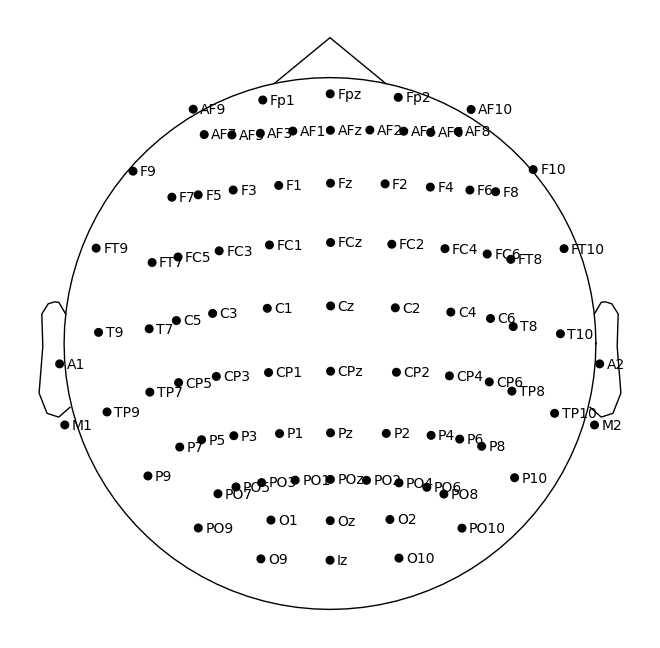

In [66]:
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
fig = ten_twenty_montage.plot(kind='3d')
fig.gca().view_init(azim=70, elev=15)
ten_twenty_montage.plot(kind='topomap', show_names=True)

In [67]:
for i in range(num_subject):
    notch_filter_pick_avg_ref[i].set_montage(ten_twenty_montage)

# ICA

## Fit to ICA

In [68]:
ica = ICA(n_components=4, random_state=97)
reconst_raw = notch_filter_pick_avg_ref.copy()

<ipython-input-68-b6d2112a3f8e>:1: DeprecationWarning:

Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.



In [69]:
artefact = [[0],[3],[],[1],[0],[2],[0],[1],[0],[],[0],[2],[0],[0],[0],[0],[0,1],[0],[1],[0],[0],[0],[0],[0],[0],[1],
            [1],[1]]

In [70]:
for i in range(num_subject):
    ica.fit(notch_filter_pick_avg_ref[i])
    ica.exclude = artefact[i]
    ica.apply(reconst_raw[i])

Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 1 ICA component
    Projecting back using 4 PCA components
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 0.1s.
Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 1 ICA component
    Projecting back using 4 PCA components
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 0.1s.
Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 0 ICA components
    Projecting back using 4 PCA components
Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 0.3s.
Appl

## Filtering again 

In [71]:
l_freq = 0.1
h_freq = 45

filter_reconst = []
for i in range(num_subject):
    temp_filter_reconst = reconst_raw[i].filter(l_freq, h_freq, picks=None, filter_length='auto', 
                                        l_trans_bandwidth='auto', h_trans_bandwidth='auto', 
                                        n_jobs=1, method='fir', iir_params=None, phase='zero', 
                                        fir_window='hamming', fir_design='firwin', 
                                        pad='reflect_limited', verbose=None)

    filter_reconst.append(temp_filter_reconst)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 4225 samples (33.008 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband

- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 4225 samples (33.008 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 4225 samples (33.008 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandp

# Epoching data

## Markers data

In [72]:
epochs = []
for i in range(num_subject):
    temp_events = np.array((markers[i])[["latency","marker","marker"]])
    temp_epochs = mne.Epochs(filter_reconst[i], temp_events, event_id = event_ids, tmin = - 0.5, tmax = 3, baseline=None, picks=None, 
                    preload=False, reject=None, flat=None, proj=True, decim=1, reject_tmin=None, 
                    reject_tmax=None, detrend=None, on_missing='warning', reject_by_annotation=True, 
                    metadata=None, event_repeated='error', verbose=None)
    epochs.append(temp_epochs)
    

Not setting metadata
Not setting metadata
54 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
Not setting metadata
55 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
Not setting metadata
54 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
Not setting metadata
54 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
Not setting metadata
54 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
Not setting metadata
54 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
Not setting metadata
54 matching events found
No baseline correction applied
0 projection 

# Band power analysis

In [73]:
n_fft = 2048
eyes_open = []
eyes_close = []

for i in range(num_subject):
    temp_eyesopen = (epochs[i])[0]
    temp_eyesclose = (epochs[i])[2]
    eyes_open.append(temp_eyesopen)
    eyes_close.append(temp_eyesclose)   

### Multitaper technique

In [74]:
def bandpower(data, sf, low, high, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    sf : float
      Sampling frequency of the data.
    band : list
      Lower and upper frequencies of the band of interest.
    method : string
      Periodogram method: 'welch' or 'multitaper'
    window_sec : float
      Length of each window in seconds. Useful only if method == 'welch'.
      If None, window_sec = (1 / min(band)) * 2.
    relative : boolean
      If True, return the relative power (= divided by the total power of the signal).
      If False (default), return the absolute power.

    Return
    ------
    bp : float
      Absolute or relative band power.
    """
    from scipy.integrate import simps
    from mne.time_frequency import psd_array_multitaper

    # Compute the modified periodogram (Welch)
    psd_total, freqs_total = psd_multitaper(data, low_bias=True, proj=False, n_jobs=1)
    psd, freqs = psd_multitaper(data, fmin=low, fmax=high, low_bias=True, proj=False, n_jobs=1)

    # Frequency resolution
    freq_res = freqs_total[1] - freqs_total[0]

    # Find index of band in frequency vector
    # idx_band = np.logical_and(psd[:,] >= low, psd[:,] <= high)
    
    # Integral approximation of the spectrum using parabola (Simpson's rule)
    bp = simps(psd, dx=freq_res)
  
    if relative:
        bp = simps(psd, dx=freq_res) / simps(psd_total, dx=freq_res) # bandpower per channel 
        avg = np.average(bp) # average bandpower from all channels 
        bp_new = np.append(bp, avg)
    
    
    return bp_new 

In [75]:
sf = 128
delta_low = 0.5
delta_high = 4

theta_low = 4
theta_high = 8

alpha_low = 8
alpha_high = 12

beta_low = 12
beta_high = 30

In [76]:
bp_delta_open = []
bp_theta_open = []
bp_alpha_open = []
bp_beta_open = []

bp_delta_close = []
bp_theta_close = []
bp_alpha_close = []
bp_beta_close = []

In [77]:
for i in range(num_subject):
    temp_bp_delta_open = bandpower(eyes_open[i], sf, low=delta_low, high=delta_high, window_sec=None, relative=True)
    temp_bp_theta_open = bandpower(eyes_open[i], sf, low=theta_low, high=theta_high, window_sec=None, relative=True)
    temp_bp_alpha_open = bandpower(eyes_open[i], sf, low=alpha_low, high=alpha_high, window_sec=None, relative=True)
    temp_bp_beta_open = bandpower(eyes_open[i], sf, low=beta_low, high=beta_high, window_sec=None, relative=True)
    
    temp_bp_delta_close = bandpower(eyes_close[i], sf, low=delta_low, high=delta_high, window_sec=None, relative=True)
    temp_bp_theta_close = bandpower(eyes_close[i], sf, low=theta_low, high=theta_high, window_sec=None, relative=True)
    temp_bp_alpha_close = bandpower(eyes_close[i], sf, low=alpha_low, high=alpha_high, window_sec=None, relative=True)
    temp_bp_beta_close = bandpower(eyes_close[i], sf, low=beta_low, high=beta_high, window_sec=None, relative=True)
    
    bp_delta_open.append(temp_bp_delta_open)
    bp_theta_open.append(temp_bp_theta_open)
    bp_alpha_open.append(temp_bp_alpha_open)
    bp_beta_open.append(temp_bp_beta_open)
    
    bp_delta_close.append(temp_bp_delta_close)
    bp_theta_close.append(temp_bp_theta_close)
    bp_alpha_close.append(temp_bp_alpha_close)
    bp_beta_close.append(temp_bp_beta_close)

Loading data for 1 events and 449 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 

Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 

Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 

Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 

Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 

Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 

Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1 

In [78]:
np.shape(bp_delta_open[0])

(5,)

In [79]:
df_eyes_open_delta = pd.DataFrame(bp_delta_open, columns=['ch1','ch2','ch3','ch4','average'])
index = df_eyes_open_delta.index
index.name = "Subject"

df_eyes_open_theta = pd.DataFrame(bp_theta_open, columns=['ch1','ch2','ch3','ch4','average'])
index = df_eyes_open_theta.index
index.name = "Subject"

df_eyes_open_alpha = pd.DataFrame(bp_alpha_open, columns=['ch1','ch2','ch3','ch4','average'])
index = df_eyes_open_alpha.index
index.name = "Subject"

df_eyes_open_beta = pd.DataFrame(bp_beta_open, columns=['ch1','ch2','ch3','ch4','average'])
index = df_eyes_open_beta.index
index.name = "Subject"

df_eyes_close_delta = pd.DataFrame(bp_delta_close, columns=['ch1','ch2','ch3','ch4','average'])
index = df_eyes_close_delta.index
index.name = "Subject"

df_eyes_close_theta = pd.DataFrame(bp_theta_close, columns=['ch1','ch2','ch3','ch4','average'])
index = df_eyes_close_theta.index
index.name = "Subject"

df_eyes_close_alpha = pd.DataFrame(bp_alpha_close, columns=['ch1','ch2','ch3','ch4','average'])
index = df_eyes_close_alpha.index
index.name = "Subject"

df_eyes_close_beta = pd.DataFrame(bp_beta_close, columns=['ch1','ch2','ch3','ch4','average'])
index = df_eyes_close_beta.index
index.name = "Subject"

In [80]:
# display(HTML(df_eyes_close_beta.to_html()))

In [81]:
# global plotting
gl_open_delta_mean = []
gl_open_delta_se = []

gl_close_delta_mean = []
gl_close_delta_se = []

gl_open_theta_mean = []
gl_open_theta_se = []

gl_close_theta_mean = []
gl_close_theta_se = []

gl_open_alpha_mean = []
gl_open_alpha_se = []

gl_close_alpha_mean = []
gl_close_alpha_se = []

gl_open_beta_mean = []
gl_open_beta_se = []

gl_close_beta_mean = []
gl_close_beta_se = []

for i in range(num_ch+1):
    gl_open_delta_mean.append(df_eyes_open_delta.loc[i].mean())
    gl_open_delta_se.append(df_eyes_open_delta.loc[i].std()/np.sqrt(num_subject)) 
    
    gl_close_delta_mean.append(df_eyes_close_delta.loc[i].mean())
    gl_close_delta_se.append(df_eyes_close_delta.loc[i].std()/np.sqrt(num_subject))
    
    gl_open_theta_mean.append(df_eyes_open_theta.loc[i].mean())
    gl_open_theta_se.append(df_eyes_open_theta.loc[i].std()/np.sqrt(num_subject)) 
    
    gl_close_theta_mean.append(df_eyes_close_theta.loc[i].mean())
    gl_close_theta_se.append(df_eyes_close_theta.loc[i].std()/np.sqrt(num_subject))
    
    gl_open_alpha_mean.append(df_eyes_open_alpha.loc[i].mean())
    gl_open_alpha_se.append(df_eyes_open_alpha.loc[i].std()/np.sqrt(num_subject)) 
    
    gl_close_alpha_mean.append(df_eyes_close_alpha.loc[i].mean())
    gl_close_alpha_se.append(df_eyes_close_alpha.loc[i].std()/np.sqrt(num_subject))
    
    gl_open_beta_mean.append(df_eyes_open_beta.loc[i].mean())
    gl_open_beta_se.append(df_eyes_open_beta.loc[i].std()/np.sqrt(num_subject)) 
    
    gl_close_beta_mean.append(df_eyes_close_beta.loc[i].mean())
    gl_close_beta_se.append(df_eyes_close_beta.loc[i].std()/np.sqrt(num_subject))

In [82]:
# Eyes open bandpowers
fig = go.Figure()
fig.add_trace(go.Bar(name='Delta', x=['ch1','ch2','ch3','ch4','average'], y=gl_open_delta_mean, 
                     error_y=dict(type='data', array=gl_open_delta_se)))

fig.add_trace(go.Bar(name='Theta', x=['ch1','ch2','ch3','ch4','average'], y=gl_open_theta_mean,
                     error_y=dict(type='data', array=gl_open_theta_se)))

fig.add_trace(go.Bar(name='Alpha', x=['ch1','ch2','ch3','ch4','average'], y=gl_open_alpha_mean,
                     error_y=dict(type='data', array=gl_open_alpha_se)))

fig.add_trace(go.Bar(name='Beta', x=['ch1','ch2','ch3','ch4','average'], y=gl_open_beta_mean,
                     error_y=dict(type='data', array=gl_open_beta_se)))

fig.update_layout(barmode='group',title="Eyes Open Bandpower")
fig.show()

# Eyes close bandpowers
fig = go.Figure()
fig.add_trace(go.Bar(name='Delta', x=['ch1','ch2','ch3','ch4','average'], y=gl_close_delta_mean, 
                     error_y=dict(type='data', array=gl_close_delta_se)))

fig.add_trace(go.Bar(name='Theta', x=['ch1','ch2','ch3','ch4','average'], y=gl_close_theta_mean,
                     error_y=dict(type='data', array=gl_close_theta_se)))

fig.add_trace(go.Bar(name='Alpha', x=['ch1','ch2','ch3','ch4','average'], y=gl_close_alpha_mean,
                     error_y=dict(type='data', array=gl_close_alpha_se)))

fig.add_trace(go.Bar(name='Beta', x=['ch1','ch2','ch3','ch4','average'], y=gl_close_beta_mean,
                     error_y=dict(type='data', array=gl_close_beta_se)))

fig.update_layout(barmode='group',title="Eyes Close Bandpower")
fig.show()

In [85]:
# plotting bandpower of each band 
fig = go.Figure()
fig.add_trace(go.Bar(name='Eyes Open', x=['ch1','ch2','ch3','ch4','average'], y=gl_open_delta_mean, 
                     error_y=dict(type='data', array=gl_open_delta_se)))

fig.add_trace(go.Bar(name='Eyes Close', x=['ch1','ch2','ch3','ch4','average'], y=gl_close_delta_mean,
                     error_y=dict(type='data', array=gl_close_delta_se)))
fig.update_layout(barmode='group',title="Delta bandpower")
fig.show()

fig = go.Figure()
fig.add_trace(go.Bar(name='Eyes Open', x=['ch1','ch2','ch3','ch4','average'], y=gl_open_theta_mean, 
                     error_y=dict(type='data', array=gl_open_theta_se)))

fig.add_trace(go.Bar(name='Eyes Close', x=['ch1','ch2','ch3','ch4','average'], y=gl_close_theta_mean,
                     error_y=dict(type='data', array=gl_close_theta_se)))
fig.update_layout(barmode='group',title="Theta bandpower")
fig.show()

fig = go.Figure()
fig.add_trace(go.Bar(name='Eyes Open', x=['ch1','ch2','ch3','ch4','average'], y=gl_open_alpha_mean, 
                     error_y=dict(type='data', array=gl_open_alpha_se)))

fig.add_trace(go.Bar(name='Eyes Close', x=['ch1','ch2','ch3','ch4','average'], y=gl_close_alpha_mean,
                     error_y=dict(type='data', array=gl_close_alpha_se)))
fig.update_layout(barmode='group',title="Alpha bandpower")
fig.show()

fig = go.Figure()
fig.add_trace(go.Bar(name='Eyes Open', x=['ch1','ch2','ch3','ch4','average'], y=gl_open_beta_mean, 
                     error_y=dict(type='data', array=gl_open_beta_se)))

fig.add_trace(go.Bar(name='Eyes Close', x=['ch1','ch2','ch3','ch4','average'], y=gl_close_beta_mean,
                     error_y=dict(type='data', array=gl_close_beta_se)))
fig.update_layout(barmode='group',title="Beta bandpower")
fig.show()

# Behavioural data

In [142]:
beh_data = []
outcome = []
for i in range(num_subject):
    # generate temporary filename in the format - "outcome1.xlsx"
    temp_filename = "outcome{m}.xlsx".format(m=i+1)
    
    # creating dataframe from this xlsx file
    temp_beh_data = pd.read_excel(temp_filename, header=None)
    temp_beh_data = temp_beh_data.drop(temp_beh_data.columns[[3]], axis=1)
    temp_beh_data.columns =['Outcome', 'Emo', 'Foc']
    temp_outcome = temp_beh_data["Outcome"]
    outcome.append(temp_outcome)
    
    index = temp_beh_data.index
    index.name = "Subject"
    beh_data.append(temp_beh_data)

## Dynamic class labeling of Emo and Foc 

In [143]:
emo_dyn = []
foc_dyn = []

for i in range(num_subject):
    temp_emo = beh_data[i]["Emo"]
    temp_emo = temp_emo.to_numpy()
    
    temp_foc = beh_data[i]["Foc"]
    temp_foc = temp_foc.to_numpy()
    
    temp_emo_max = np.max(temp_emo)
    temp_foc_max = np.max(temp_foc)
    
    # initialisation of dynamic quartile boundaries 
    
    temp_emo_quartile1 = np.quantile(temp_emo, .25, interpolation='midpoint') 
    temp_emo_quartile2 = np.quantile(temp_emo, .50, interpolation='midpoint')
    temp_emo_quartile3 = np.quantile(temp_emo, .75, interpolation='midpoint')

    temp_foc_quartile1 = np.quantile(temp_foc, .25, interpolation='midpoint') 
    temp_foc_quartile2 = np.quantile(temp_foc, .50, interpolation='midpoint')
    temp_foc_quartile3 = np.quantile(temp_foc, .75, interpolation='midpoint')
    
    temp_emo_dyn = np.zeros(len(temp_emo))
    temp_foc_dyn = np.zeros(len(temp_foc))
    
    # dynamic quartile labeling 
    for i in range(len(temp_emo)):
        if temp_emo[i]<temp_emo_quartile1:
            temp_emo_dyn[i]=int(0)
        else:
            if temp_emo[i]<temp_emo_quartile2:
                temp_emo_dyn[i]=int(1)
            else:
                if temp_emo[i]<temp_emo_quartile3:
                    temp_emo_dyn[i]=int(2)
                else:
                    if temp_emo[i]<=temp_emo_max:
                        temp_emo_dyn[i]=int(3)
                        
    for i in range(len(temp_foc)):
        if temp_foc[i]<temp_foc_quartile1:
            temp_foc_dyn[i]=int(0)
        else:
            if temp_foc[i]<temp_foc_quartile2:
                temp_foc_dyn[i]=int(1)
            else:
                if temp_foc[i]<temp_foc_quartile3:
                    temp_foc_dyn[i]=int(2)
                else:
                    if temp_foc[i]<=temp_foc_max:
                        temp_foc_dyn[i]=int(3)
    
    temp_emo_dyn = temp_emo_dyn.astype(int)
    temp_foc_dyn = temp_foc_dyn.astype(int)
    emo_dyn.append(temp_emo_dyn)
    foc_dyn.append(temp_foc_dyn)
    

In [88]:
# emo_dyn = dynamic emotion rating of each subject
# foc_dyn = dynamic focus rating of each subject
# outcome = win/loss outcome for each subject 

In [146]:
# print(outcome[0])

## Plotting behavioural data

In [147]:
# frequency plot for outcome of the trial 
import plotly.express as px
outcome_freq = []
for i in range(num_subject):
    outcome_freq.append(outcome[i].value_counts()[1])

fig = px.scatter(x=[range(1,num_subject+1)], y=outcome_freq)
fig.add_hline(y=25, line_width=3, line_dash="dash", line_color="green",annotation_text="50% trials")
# fig.add_hrect(y0=25, y1=30, line_width=0, fillcolor="red", opacity=0.2)
fig. update_layout(title="Number of winning trials for each subject", xaxis=dict(title='Subject',tickmode='linear'), 
                   yaxis_title="Number of trials")
fig.show()

In [211]:
num_trial = 50
freq_trial_subject = []

for i in range(num_trial):
    temp_freq = 0
    for j in range(num_subject):
        temp_outcome = outcome[j].to_numpy()
        if temp_outcome[i]==1:
            temp_freq = temp_freq + 1
    freq_trial_subject.append(temp_freq/num_subject)

fig = px.scatter(x=[range(1,num_trial+1)],y=freq_trial_subject,trendline="rolling", 
                 trendline_options=dict(window=5, win_type="gaussian", function_args=dict(std=2)),
                 trendline_color_override="green")
# fig = px.scatter(x=[range(1,num_trial+1)],y=freq_trial_subject,trendline="loweess",trendline_color_override="red")

fig. update_layout(title="Proportion of winning subjects", xaxis=dict(title='Trial number'), 
                   yaxis=dict(title="Proportion of subjects"))
fig.show()

In [209]:
from plotly.subplots import make_subplots 

trials = np.array(range(1,num_trial+1))
subject = 0

df = pd.DataFrame(trials,columns=["trial_number"]) 

trace1 = go.Scatter(x=df["trial_number"],y=outcome[subject], name='Trial outcome',yaxis='y2')
trace2 = go.Scatter(x=df["trial_number"],y=emo_dyn[subject], name='EMO rating',yaxis='y2')

fig1 = make_subplots()
fig1.add_trace(trace1)
fig1.add_trace(trace2)

iplot(fig1)

trace3 = go.Scatter(x=df["trial_number"],y=outcome[subject], name='Trial outcome',yaxis='y2')
trace4 = go.Scatter(x=df["trial_number"],y=foc_dyn[subject], name='FOC rating',yaxis='y2')

fig2 = make_subplots()
fig2.add_trace(trace3)
fig2.add_trace(trace4)

iplot(fig2)

# Creating X and y

In [94]:
num_trial = 50
num_ch = 4
y = [] # outcome corresponding to each timestamp of each trial
y_emo_dyn = [] # emotion rating corresponding to each timestamp of each trial
y_foc_dyn = [] # focus rating corresponding to each timestamp of each trial
X = [] # channel data and epoch information 
X_ch = [] # channel data
X_ch_avg = [] # channel data with average over each trial 

for i in range(num_subject):
    temp_df = epochs[i][4:num_trial+4].to_data_frame()
    temp_X = temp_df.to_numpy()
    X.append(temp_X)
    temp_X_ch = temp_X[:,3:num_ch+3]
    X_ch.append(temp_X_ch)
    
    temp_X_ch_avg = np.zeros((num_trial,num_ch))

    for k in range(4,num_trial+4):
        temp_df_trial = temp_df.loc[np.where(temp_df['epoch'] == k)]
        temp_X_trial = temp_df_trial.to_numpy()
        temp_X_trial = temp_X_trial[:,3:7] 
        temp_X_trial = np.mean(temp_X_trial,0)
        temp_X_ch_avg[k-4,:] = temp_X_trial
        
    X_ch_avg.append(temp_X_ch_avg)

    
    temp_y = np.empty(len(temp_X))
    temp_y_emo_dyn = np.empty(len(temp_X))
    temp_y_foc_dyn = np.empty(len(temp_X))
    for j in range(4,num_trial+4):
        temp_outcome = beh_data[i][["Outcome"]].to_numpy()
        idx = np.where(temp_df['epoch']==j)
        temp_y[idx] = temp_outcome[j-4]
        
        
        temp_emo = emo_dyn[i]
        temp_y_emo_dyn[idx] = temp_emo[j-4]
        
        temp_foc = foc_dyn[i]
        temp_y_foc_dyn[idx] = temp_foc[j-4]
            
    y.append(temp_y)
    y_emo_dyn.append(temp_y_emo_dyn)
    y_foc_dyn.append(temp_y_foc_dyn)
    
    

Loading data for 50 events and 449 original time points ...
0 bad epochs dropped
Loading data for 50 events and 449 original time points ...
0 bad epochs dropped
Loading data for 50 events and 449 original time points ...
0 bad epochs dropped
Loading data for 50 events and 449 original time points ...
0 bad epochs dropped
Loading data for 50 events and 449 original time points ...
0 bad epochs dropped
Loading data for 50 events and 449 original time points ...
0 bad epochs dropped
Loading data for 50 events and 449 original time points ...
0 bad epochs dropped
Loading data for 50 events and 449 original time points ...
0 bad epochs dropped
Loading data for 50 events and 449 original time points ...
0 bad epochs dropped
Loading data for 50 events and 449 original time points ...
0 bad epochs dropped
Loading data for 50 events and 449 original time points ...
0 bad epochs dropped
Loading data for 50 events and 449 original time points ...
0 bad epochs dropped
Loading data for 50 events a

# Function to predict outcome/emo/foc

In [95]:
def predict_outcome(X, y,choose_model, round_off):
    
    # output
    # scores_roc = [ch1_roc, ch2_roc, ch3_roc, ch4_roc, total_roc]
    # scores_acc = [ch1_acc, ch2_acc, ch3_acc, ch4_acc, total_acc]
    
    # choose model
    if choose_model == 'lda':
        model = LinearDiscriminantAnalysis()
    elif choose_model == 'reg':
        model = LogisticRegression()
    elif choose_model == 'svm':
        model = LinearSVC(dual=True)
    
    # define model evaluation method
    n_splits = 5
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=3, random_state=1)
    
    mean_scores_roc = []
    mean_scores_acc = []
    
    se_scores_roc = []
    se_scores_acc = []
    
    # choose column data 
    X_ch1 = X[:,0].reshape(-1,1)
    X_ch2 = X[:,1].reshape(-1,1)
    X_ch3 = X[:,2].reshape(-1,1)
    X_ch4 = X[:,3].reshape(-1,1)
      
    # evaluate model
    # column wise 
    mean_scores_roc1 = round(np.mean(cross_val_score(model, X_ch1, y, scoring='roc_auc', cv=cv, n_jobs= -1)),round_off)
    mean_scores_roc2 = round(np.mean(cross_val_score(model, X_ch2, y, scoring='roc_auc', cv=cv, n_jobs= -1)),round_off)
    mean_scores_roc3 = round(np.mean(cross_val_score(model, X_ch3, y, scoring='roc_auc', cv=cv, n_jobs= -1)),round_off)
    mean_scores_roc4 = round(np.mean(cross_val_score(model, X_ch4, y, scoring='roc_auc', cv=cv, n_jobs= -1)),round_off)
    mean_scores_roc_total = round(np.mean(cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs= -1)),round_off)

    mean_scores_acc1 = round(np.mean(cross_val_score(model, X_ch1, y, scoring='accuracy', cv=cv, n_jobs= -1))*100,round_off)
    mean_scores_acc2 = round(np.mean(cross_val_score(model, X_ch2, y, scoring='accuracy', cv=cv, n_jobs= -1))*100,round_off)
    mean_scores_acc3 = round(np.mean(cross_val_score(model, X_ch3, y, scoring='accuracy', cv=cv, n_jobs= -1))*100,round_off)
    mean_scores_acc4 = round(np.mean(cross_val_score(model, X_ch4, y, scoring='accuracy', cv=cv, n_jobs= -1))*100,round_off)
    mean_scores_acc_total = round(np.mean(cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs= -1))*100,round_off)
    
    mean_scores_roc.append(mean_scores_roc1)
    mean_scores_roc.append(mean_scores_roc2)
    mean_scores_roc.append(mean_scores_roc3)
    mean_scores_roc.append(mean_scores_roc4)
    mean_scores_roc.append(mean_scores_roc_total)
    
    mean_scores_acc.append(mean_scores_acc1)
    mean_scores_acc.append(mean_scores_acc2)
    mean_scores_acc.append(mean_scores_acc3)
    mean_scores_acc.append(mean_scores_acc4)
    mean_scores_acc.append(mean_scores_acc_total)
    
    std_scores_roc1 = np.std(cross_val_score(model, X_ch1, y, scoring='roc_auc', cv=cv, n_jobs= -1))
    std_scores_roc2 = np.std(cross_val_score(model, X_ch2, y, scoring='roc_auc', cv=cv, n_jobs= -1))
    std_scores_roc3 = np.std(cross_val_score(model, X_ch3, y, scoring='roc_auc', cv=cv, n_jobs= -1))
    std_scores_roc4 = np.std(cross_val_score(model, X_ch4, y, scoring='roc_auc', cv=cv, n_jobs= -1))
    std_scores_roc_total = np.std(cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs= -1))
    
    std_scores_acc1 = np.std(cross_val_score(model, X_ch1, y, scoring='accuracy', cv=cv, n_jobs= -1))*100
    std_scores_acc2 = np.std(cross_val_score(model, X_ch2, y, scoring='accuracy', cv=cv, n_jobs= -1))*100
    std_scores_acc3 = np.std(cross_val_score(model, X_ch3, y, scoring='accuracy', cv=cv, n_jobs= -1))*100
    std_scores_acc4 = np.std(cross_val_score(model, X_ch4, y, scoring='accuracy', cv=cv, n_jobs= -1))*100
    std_scores_acc_total = np.std(cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs= -1))*100
    
    se_scores_roc1 = round(std_scores_roc1/np.sqrt(n_splits),round_off)
    se_scores_roc2 = round(std_scores_roc2/np.sqrt(n_splits),round_off)
    se_scores_roc3 = round(std_scores_roc3/np.sqrt(n_splits),round_off)
    se_scores_roc4 = round(std_scores_roc4/np.sqrt(n_splits),round_off)
    se_scores_roc_total = round(std_scores_roc_total/np.sqrt(n_splits),round_off)
    
    se_scores_acc1 = round(std_scores_acc1/np.sqrt(n_splits),round_off)
    se_scores_acc2 = round(std_scores_acc2/np.sqrt(n_splits),round_off)
    se_scores_acc3 = round(std_scores_acc3/np.sqrt(n_splits),round_off)
    se_scores_acc4 = round(std_scores_acc4/np.sqrt(n_splits),round_off)
    se_scores_acc_total = round(std_scores_acc_total/np.sqrt(n_splits),round_off)
    
    se_scores_roc.append(se_scores_roc1)
    se_scores_roc.append(se_scores_roc2)
    se_scores_roc.append(se_scores_roc3)
    se_scores_roc.append(se_scores_roc4)
    se_scores_roc.append(se_scores_roc_total)
    
    se_scores_acc.append(se_scores_acc1)
    se_scores_acc.append(se_scores_acc2)
    se_scores_acc.append(se_scores_acc3)
    se_scores_acc.append(se_scores_acc4)
    se_scores_acc.append(se_scores_acc_total)
    
    return mean_scores_roc, se_scores_roc, mean_scores_acc, se_scores_acc
        

# Predicting outcome using X_ch_avg

In [96]:
mean_roc_lda = []
mean_acc_lda = []

mean_roc_reg = []
mean_acc_reg = []

mean_roc_svm = []
mean_acc_svm = []

se_roc_lda = []
se_acc_lda = []

se_roc_reg = []
se_acc_reg = []

se_roc_svm = []
se_acc_svm = []

for i in range(num_subject):
    
    model = 'lda'
    round_off = 2
    temp_mean_roc_lda, temp_se_roc_lda, temp_mean_acc_lda, temp_se_acc_lda = predict_outcome(X_ch_avg[i],outcome[i],model,round_off)
    mean_roc_lda.append(temp_mean_roc_lda)
    mean_acc_lda.append(temp_mean_acc_lda)
    se_roc_lda.append(temp_se_roc_lda)
    se_acc_lda.append(temp_se_acc_lda)
    
    model = 'reg'
    round_off = 2
    temp_mean_roc_reg, temp_se_roc_reg, temp_mean_acc_reg, temp_se_acc_reg = predict_outcome(X_ch_avg[i],outcome[i],model,round_off)
    mean_roc_reg.append(temp_mean_roc_reg)
    mean_acc_reg.append(temp_mean_acc_reg)
    se_roc_reg.append(temp_se_roc_reg)
    se_acc_reg.append(temp_se_acc_reg)
    
    model = 'svm'
    round_off = 2
    temp_mean_roc_svm, temp_se_roc_svm, temp_mean_acc_svm, temp_se_acc_svm = predict_outcome(X_ch_avg[i],outcome[i],model,round_off)
    mean_roc_svm.append(temp_mean_roc_svm)
    mean_acc_svm.append(temp_mean_acc_svm)
    se_roc_svm.append(temp_se_roc_svm)
    se_acc_svm.append(temp_se_acc_svm)
    
    
    

In [100]:
df_mean_roc_lda = pd.DataFrame(mean_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_mean_roc_lda.index
index.name = "Subject"

df_se_roc_lda = pd.DataFrame(se_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_mean_roc_lda.index
index.name = "Subject"

df_mean_acc_lda = pd.DataFrame(mean_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_mean_roc_lda.index
index.name = "Subject"

df_se_acc_lda = pd.DataFrame(se_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_mean_roc_lda.index
index.name = "Subject"

df_mean_roc_reg = pd.DataFrame(mean_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_mean_roc_lda.index
index.name = "Subject"

df_se_roc_reg = pd.DataFrame(se_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_mean_roc_lda.index
index.name = "Subject"

df_mean_acc_reg = pd.DataFrame(mean_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_mean_roc_lda.index
index.name = "Subject"

df_se_acc_reg = pd.DataFrame(se_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_mean_roc_lda.index
index.name = "Subject"

df_mean_roc_svm = pd.DataFrame(mean_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_mean_roc_lda.index
index.name = "Subject"

df_se_roc_svm = pd.DataFrame(se_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_mean_roc_lda.index
index.name = "Subject"

df_mean_acc_svm = pd.DataFrame(mean_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_mean_roc_lda.index
index.name = "Subject"

df_se_acc_svm = pd.DataFrame(se_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_mean_roc_lda.index
index.name = "Subject"

In [98]:
# display(HTML(df_se_acc_reg.to_html()))

In [101]:
## Plotting - method wise 
# global plotting
gl_X_avg_lda_acc_mean = []
gl_X_avg_lda_acc_se = []

gl_X_avg_lda_roc_mean = []
gl_X_avg_lda_roc_se = []

gl_X_avg_reg_acc_mean = []
gl_X_avg_reg_acc_se = []

gl_X_avg_reg_roc_mean = []
gl_X_avg_reg_roc_se = []

gl_X_avg_svm_acc_mean = []
gl_X_avg_svm_acc_se = []

gl_X_avg_svm_roc_mean = []
gl_X_avg_svm_roc_se = []

for i in range(num_ch+1):
    gl_X_avg_lda_acc_mean.append(df_mean_acc_lda.loc[i].mean())
    gl_X_avg_lda_acc_se.append(df_mean_acc_lda.loc[i].std()/np.sqrt(num_subject)) 
    
    gl_X_avg_lda_roc_mean.append(df_mean_roc_lda.loc[i].mean())
    gl_X_avg_lda_roc_se.append(df_mean_roc_lda.loc[i].std()/np.sqrt(num_subject))
    
    gl_X_avg_reg_acc_mean.append(df_mean_acc_reg.loc[i].mean())
    gl_X_avg_reg_acc_se.append(df_mean_acc_reg.loc[i].std()/np.sqrt(num_subject)) 
    
    gl_X_avg_reg_roc_mean.append(df_mean_roc_reg.loc[i].mean())
    gl_X_avg_reg_roc_se.append(df_mean_roc_reg.loc[i].std()/np.sqrt(num_subject))
    
    gl_X_avg_svm_acc_mean.append(df_mean_acc_svm.loc[i].mean())
    gl_X_avg_svm_acc_se.append(df_mean_acc_svm.loc[i].std()/np.sqrt(num_subject)) 
    
    gl_X_avg_svm_roc_mean.append(df_mean_roc_svm.loc[i].mean())
    gl_X_avg_svm_roc_se.append(df_mean_roc_svm.loc[i].std()/np.sqrt(num_subject))

In [102]:
# Accuracy predicting outcome 
fig = go.Figure()
fig.add_trace(go.Bar(name='LDA', x=['ch1','ch2','ch3','ch4','average'], y=gl_X_avg_lda_acc_mean, 
                     error_y=dict(type='data', array=gl_X_avg_lda_acc_se)))


fig.add_trace(go.Bar(name='Logistic Regression', x=['ch1','ch2','ch3','ch4','average'], y=gl_X_avg_reg_acc_mean,
                     error_y=dict(type='data', array=gl_X_avg_reg_acc_se)))

fig.add_trace(go.Bar(name='SVM', x=['ch1','ch2','ch3','ch4','average'], y=gl_X_avg_svm_acc_mean,
                     error_y=dict(type='data', array=gl_X_avg_svm_acc_se)))

fig.update_layout(barmode='group',title="Accuracy - Average trial signal predicting outcome",yaxis_title="Accuracy")
fig.show()

# Roc of outcome prediction 
fig = go.Figure()
fig.add_trace(go.Bar(name='LDA', x=['ch1','ch2','ch3','ch4','average'], y=gl_X_avg_lda_roc_mean, 
                     error_y=dict(type='data', array=gl_X_avg_lda_roc_se)))


fig.add_trace(go.Bar(name='Logistic Regression', x=['ch1','ch2','ch3','ch4','average'], y=gl_X_avg_reg_roc_mean,
                     error_y=dict(type='data', array=gl_X_avg_reg_roc_se)))

fig.add_trace(go.Bar(name='SVM', x=['ch1','ch2','ch3','ch4','average'], y=gl_X_avg_svm_roc_mean,
                     error_y=dict(type='data', array=gl_X_avg_svm_roc_se)))

fig.update_layout(barmode='group',title="ROC - Average trial signal predicting outcome",yaxis_title="ROC")
fig.show()

In [ ]:
# Worst to Best channel for each subject 
# global plotting
# gl_X_avg_lda_acc_mean = []
# gl_X_avg_lda_acc_se = []

# gl_X_avg_lda_roc_mean = []
# gl_X_avg_lda_roc_se = []

# gl_X_avg_reg_acc_mean = []
# gl_X_avg_reg_acc_se = []

# gl_X_avg_reg_roc_mean = []
# gl_X_avg_reg_roc_se = []

# gl_X_avg_svm_acc_mean = []
# gl_X_avg_svm_acc_se = []

# gl_X_avg_svm_roc_mean = []
# gl_X_avg_svm_roc_se = []

x_axis = ['ch1','ch2','ch3','ch4','average']

# X using values from Y
# Z = [x for _,x in sorted(zip(Y,X))]

gl_X_avg_lda_acc_se_sorted = []
for i in range(num_subject):
    temp_gl_X_avg_lda_acc_se_sorted = gl_X_avg_lda_acc_se[gl_X_avg_lda_acc_mean[i].argsort()]
    gl_X_avg_lda_acc_se_sorted.append(temp_gl_X_avg_lda_acc_se_sorted)
    
    temp_gl_X_avg_lda_acc_mean_sorted = gl_X_avg_lda_acc_mean[gl_X_avg_lda_acc_mean[i].argsort()]
    gl_X_avg_lda_acc_mean_sorted.append(temp_gl_X_avg_lda_acc_mean_sorted)

# Function to predict emo/foc 

In [ ]:
def predict_rating(X, y,choose_model, round_off):
    
    # output
    # scores_roc = [ch1_roc, ch2_roc, ch3_roc, ch4_roc, total_roc]
    # scores_acc = [ch1_acc, ch2_acc, ch3_acc, ch4_acc, total_acc]
    
    # choose model
    if choose_model == 'lda':
        model = LinearDiscriminantAnalysis()
    elif choose_model == 'reg':
        model = LogisticRegression()
    elif choose_model == 'svm':
        model = LinearSVC(dual=True)
    
    # define model evaluation method
    n_splits = 5
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=3, random_state=1)
    
    mean_scores_roc = []
    mean_scores_acc = []
    
    se_scores_roc = []
    se_scores_acc = []
    
    # choose column data 
    X_ch1 = X[:,0].reshape(-1,1)
    X_ch2 = X[:,1].reshape(-1,1)
    X_ch3 = X[:,2].reshape(-1,1)
    X_ch4 = X[:,3].reshape(-1,1)
      
    # evaluate model
    # column wise 
#     mean_scores_roc1 = round(np.mean(cross_val_score(model, X_ch1, y, scoring='roc_auc', cv=cv, n_jobs= -1)),round_off)
#     mean_scores_roc2 = round(np.mean(cross_val_score(model, X_ch2, y, scoring='roc_auc', cv=cv, n_jobs= -1)),round_off)
#     mean_scores_roc3 = round(np.mean(cross_val_score(model, X_ch3, y, scoring='roc_auc', cv=cv, n_jobs= -1)),round_off)
#     mean_scores_roc4 = round(np.mean(cross_val_score(model, X_ch4, y, scoring='roc_auc', cv=cv, n_jobs= -1)),round_off)
#     mean_scores_roc_total = round(np.mean(cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs= -1)),round_off)

    mean_scores_acc1 = round(np.mean(cross_val_score(model, X_ch1, y, scoring='accuracy', cv=cv, n_jobs= -1))*100,round_off)
    mean_scores_acc2 = round(np.mean(cross_val_score(model, X_ch2, y, scoring='accuracy', cv=cv, n_jobs= -1))*100,round_off)
    mean_scores_acc3 = round(np.mean(cross_val_score(model, X_ch3, y, scoring='accuracy', cv=cv, n_jobs= -1))*100,round_off)
    mean_scores_acc4 = round(np.mean(cross_val_score(model, X_ch4, y, scoring='accuracy', cv=cv, n_jobs= -1))*100,round_off)
    mean_scores_acc_total = round(np.mean(cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs= -1))*100,round_off)
    
#     mean_scores_roc.append(mean_scores_roc1)
#     mean_scores_roc.append(mean_scores_roc2)
#     mean_scores_roc.append(mean_scores_roc3)
#     mean_scores_roc.append(mean_scores_roc4)
#     mean_scores_roc.append(mean_scores_roc_total)
    
    mean_scores_acc.append(mean_scores_acc1)
    mean_scores_acc.append(mean_scores_acc2)
    mean_scores_acc.append(mean_scores_acc3)
    mean_scores_acc.append(mean_scores_acc4)
    mean_scores_acc.append(mean_scores_acc_total)
    
#     std_scores_roc1 = round(np.std(cross_val_score(model, X_ch1, y, scoring='roc_auc', cv=cv, n_jobs= -1)),round_off)
#     std_scores_roc2 = round(np.std(cross_val_score(model, X_ch2, y, scoring='roc_auc', cv=cv, n_jobs= -1)),round_off)
#     std_scores_roc3 = round(np.std(cross_val_score(model, X_ch3, y, scoring='roc_auc', cv=cv, n_jobs= -1)),round_off)
#     std_scores_roc4 = round(np.std(cross_val_score(model, X_ch4, y, scoring='roc_auc', cv=cv, n_jobs= -1)),round_off)
#     std_scores_roc_total = round(np.std(cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs= -1)),round_off)
    
    std_scores_acc1 = round(np.std(cross_val_score(model, X_ch1, y, scoring='accuracy', cv=cv, n_jobs= -1))*100,round_off)
    std_scores_acc2 = round(np.std(cross_val_score(model, X_ch2, y, scoring='accuracy', cv=cv, n_jobs= -1))*100,round_off)
    std_scores_acc3 = round(np.std(cross_val_score(model, X_ch3, y, scoring='accuracy', cv=cv, n_jobs= -1))*100,round_off)
    std_scores_acc4 = round(np.std(cross_val_score(model, X_ch4, y, scoring='accuracy', cv=cv, n_jobs= -1))*100,round_off)
    std_scores_acc_total = round(np.std(cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs= -1))*100,round_off)
    
    se_scores_acc1 = round(std_scores_acc1/np.sqrt(n_splits),round_off)
    se_scores_acc2 = round(std_scores_acc2/np.sqrt(n_splits),round_off)
    se_scores_acc3 = round(std_scores_acc3/np.sqrt(n_splits),round_off)
    se_scores_acc4 = round(std_scores_acc4/np.sqrt(n_splits),round_off)
    se_scores_acc_total = round(std_scores_acc_total/np.sqrt(n_splits),round_off)
    
#     std_scores_roc.append(std_scores_roc1)
#     std_scores_roc.append(std_scores_roc2)
#     std_scores_roc.append(std_scores_roc3)
#     std_scores_roc.append(std_scores_roc4)
#     std_scores_roc.append(std_scores_roc_total)
    
    se_scores_acc.append(se_scores_acc1)
    se_scores_acc.append(se_scores_acc2)
    se_scores_acc.append(se_scores_acc3)
    se_scores_acc.append(se_scores_acc4)
    se_scores_acc.append(se_scores_acc_total)
    
    return mean_scores_acc, se_scores_acc
    
#     return mean_scores_roc, std_scores_roc, mean_scores_acc, std_scores_acc
        

# Predicting emo/foc using X_ch_avg

### Emo

In [ ]:
# emo_mean_roc_lda = []
emo_mean_acc_lda = []

# emo_mean_roc_reg = []
emo_mean_acc_reg = []

# emo_mean_roc_svm = []
emo_mean_acc_svm = []

# emo_se_roc_lda = []
emo_se_acc_lda = []

# emo_se_roc_reg = []
emo_se_acc_reg = []

# emo_se_roc_svm = []
emo_se_acc_svm = []

for i in range(num_subject):
    
    model = 'lda'
    round_off = 2
    temp_emo_mean_acc_lda, temp_emo_se_acc_lda = predict_rating(X_ch_avg[i],emo_dyn[i],model,round_off)
#     emo_mean_roc_lda.append(temp_emo_mean_roc_lda)
    emo_mean_acc_lda.append(temp_emo_mean_acc_lda)
#     emo_se_roc_lda.append(temp_emo_se_roc_lda)
    emo_se_acc_lda.append(temp_emo_se_acc_lda)
    
    model = 'reg'
    round_off = 2
    temp_emo_mean_acc_reg, temp_emo_se_acc_reg = predict_rating(X_ch_avg[i],emo_dyn[i],model,round_off)
#     emo_mean_roc_reg.append(temp_emo_mean_roc_reg)
    emo_mean_acc_reg.append(temp_emo_mean_acc_reg)
#     emo_se_roc_reg.append(temp_emo_se_roc_reg)
    emo_se_acc_reg.append(temp_emo_se_acc_reg)
    
    model = 'svm'
    round_off = 2
    temp_emo_mean_acc_svm, temp_emo_se_acc_svm = predict_rating(X_ch_avg[i],emo_dyn[i],model,round_off)
#     emo_mean_roc_svm.append(temp_emo_mean_roc_svm)
    emo_mean_acc_svm.append(temp_emo_mean_acc_svm)
#     emo_se_roc_svm.append(temp_emo_se_roc_svm)
    emo_se_acc_svm.append(temp_emo_se_acc_svm)
    
    
    

In [ ]:
# df_emo_mean_roc_lda = pd.DataFrame(emo_mean_roc_lda, columns=['ch1','ch2','ch3','ch4','average'])
# index = df_emo_mean_roc_lda.index
# index.name = "Subject"

# df_emo_std_roc_lda = pd.DataFrame(emo_std_roc_lda, columns=['ch1','ch2','ch3','ch4','average'])
# index = df_emo_mean_roc_lda.index
# index.name = "Subject"

df_emo_mean_acc_lda = pd.DataFrame(emo_mean_acc_lda, columns=['ch1','ch2','ch3','ch4','average'])
index = df_emo_mean_acc_lda.index
index.name = "Subject"

df_emo_se_acc_lda = pd.DataFrame(emo_se_acc_lda, columns=['ch1','ch2','ch3','ch4','average'])
index = df_emo_se_acc_lda.index
index.name = "Subject"

# df_emo_mean_roc_reg = pd.DataFrame(emo_mean_roc_reg, columns=['ch1','ch2','ch3','ch4','average'])
# index = df_emo_mean_roc_lda.index
# index.name = "Subject"

# df_emo_std_roc_reg = pd.DataFrame(emo_std_roc_reg, columns=['ch1','ch2','ch3','ch4','average'])
# index = df_emo_mean_roc_lda.index
# index.name = "Subject"

df_emo_mean_acc_reg = pd.DataFrame(emo_mean_acc_reg, columns=['ch1','ch2','ch3','ch4','average'])
index = df_emo_mean_acc_lda.index
index.name = "Subject"

df_emo_se_acc_reg = pd.DataFrame(emo_se_acc_reg, columns=['ch1','ch2','ch3','ch4','average'])
index = df_emo_se_acc_lda.index
index.name = "Subject"

df_emo_mean_acc_svm = pd.DataFrame(emo_mean_acc_svm, columns=['ch1','ch2','ch3','ch4','average'])
index = df_emo_mean_acc_lda.index
index.name = "Subject"

df_emo_se_acc_svm = pd.DataFrame(emo_se_acc_svm, columns=['ch1','ch2','ch3','ch4','average'])
index = df_emo_se_acc_lda.index
index.name = "Subject"

In [ ]:
# display(HTML(df_emo_mean_acc_lda.to_html()))

### Foc

In [ ]:
# foc_mean_roc_lda = []
foc_mean_acc_lda = []

# foc_mean_roc_reg = []
foc_mean_acc_reg = []

# foc_mean_roc_svm = []
foc_mean_acc_svm = []

# foc_se_roc_lda = []
foc_se_acc_lda = []

# foc_se_roc_reg = []
foc_se_acc_reg = []

# foc_se_roc_svm = []
foc_se_acc_svm = []

for i in range(num_subject):
    
    model = 'lda'
    round_off = 2
    temp_foc_mean_acc_lda, temp_foc_se_acc_lda = predict_rating(X_ch_avg[i],foc_dyn[i],model,round_off)
#     foc_mean_roc_lda.append(temp_foc_mean_roc_lda)
    foc_mean_acc_lda.append(temp_foc_mean_acc_lda)
#     foc_se_roc_lda.append(temp_foc_se_roc_lda)
    foc_se_acc_lda.append(temp_foc_se_acc_lda)
    
    model = 'reg'
    round_off = 2
    temp_foc_mean_acc_reg, temp_foc_se_acc_reg = predict_rating(X_ch_avg[i],foc_dyn[i],model,round_off)
#     foc_mean_roc_reg.append(temp_foc_mean_roc_reg)
    foc_mean_acc_reg.append(temp_foc_mean_acc_reg)
#     foc_se_roc_reg.append(temp_foc_se_roc_reg)
    foc_se_acc_reg.append(temp_foc_se_acc_reg)
    
    model = 'svm'
    round_off = 2
    temp_foc_mean_acc_svm, temp_foc_se_acc_svm = predict_rating(X_ch_avg[i],foc_dyn[i],model,round_off)
#     foc_mean_roc_svm.append(temp_foc_mean_roc_svm)
    foc_mean_acc_svm.append(temp_foc_mean_acc_svm)
#     foc_se_roc_svm.append(temp_foc_se_roc_svm)
    foc_se_acc_svm.append(temp_foc_se_acc_svm)
    
    
    

In [ ]:
# df_foc_mean_roc_lda = pd.DataFrame(foc_mean_roc_lda, columns=['ch1','ch2','ch3','ch4','average'])
# index = df_foc_mean_roc_lda.index
# index.name = "Subject"

# df_foc_std_roc_lda = pd.DataFrame(foc_std_roc_lda, columns=['ch1','ch2','ch3','ch4','average'])
# index = df_foc_mean_roc_lda.index
# index.name = "Subject"

df_foc_mean_acc_lda = pd.DataFrame(foc_mean_acc_lda, columns=['ch1','ch2','ch3','ch4','average'])
index = df_foc_mean_acc_lda.index
index.name = "Subject"

df_foc_se_acc_lda = pd.DataFrame(foc_se_acc_lda, columns=['ch1','ch2','ch3','ch4','average'])
index = df_foc_se_acc_lda.index
index.name = "Subject"

# df_foc_mean_roc_reg = pd.DataFrame(foc_mean_roc_reg, columns=['ch1','ch2','ch3','ch4','average'])
# index = df_foc_mean_roc_lda.index
# index.name = "Subject"

# df_foc_std_roc_reg = pd.DataFrame(foc_std_roc_reg, columns=['ch1','ch2','ch3','ch4','average'])
# index = df_foc_mean_roc_lda.index
# index.name = "Subject"

df_foc_mean_acc_reg = pd.DataFrame(foc_mean_acc_reg, columns=['ch1','ch2','ch3','ch4','average'])
index = df_foc_mean_acc_lda.index
index.name = "Subject"

df_foc_se_acc_reg = pd.DataFrame(foc_se_acc_reg, columns=['ch1','ch2','ch3','ch4','average'])
index = df_foc_se_acc_lda.index
index.name = "Subject"

df_foc_mean_acc_svm = pd.DataFrame(foc_mean_acc_svm, columns=['ch1','ch2','ch3','ch4','average'])
index = df_foc_mean_acc_lda.index
index.name = "Subject"

df_foc_se_acc_svm = pd.DataFrame(foc_se_acc_svm, columns=['ch1','ch2','ch3','ch4','average'])
index = df_foc_se_acc_lda.index
index.name = "Subject"

# Break trial into four quarters

In [103]:
def break_trial(X, y, y_emo, y_foc):
    X_new = np.insert(X, len(X[1]), y, axis=1)
    X_new = np.insert(X_new, len(X_new[1]), y_emo, axis=1)
    X_new = np.insert(X_new, len(X_new[1]), y_foc, axis=1)
    X = X_new
    
    X_q1 = np.zeros((1, len(X[1]))) 
    X_q2 = np.zeros((1, len(X[1])))
    X_q3 = np.zeros((1, len(X[1])))
    X_q4 = np.zeros((1, len(X[1])))

    
    X_q1_avg = np.zeros((num_trial,4))
    X_q2_avg = np.zeros((num_trial,4))
    X_q3_avg = np.zeros((num_trial,4))
    X_q4_avg = np.zeros((num_trial,4))
    
    for i in range(4,num_trial+4):
        X_epoq = X[np.where(X[:,2] == i)]
        epoq_size = len(X_epoq)
        quarter_size = int(np.floor(epoq_size/4))
        
        X_q1 = np.vstack((X_q1, X_epoq[0 : quarter_size]))
        X_q2 = np.vstack((X_q2, X_epoq[quarter_size : quarter_size*2]))
        X_q3 = np.vstack((X_q3, X_epoq[quarter_size*2 : quarter_size*3]))
        X_q4 = np.vstack((X_q4, X_epoq[quarter_size*3 : len(X_epoq)]))
        
        temp_X_q1 = X_q1[:,3:7]
        temp_X_q2 = X_q2[:,3:7]
        temp_X_q3 = X_q3[:,3:7]
        temp_X_q4 = X_q4[:,3:7]
        
        X_q1_avg[i-4,:] = np.mean(temp_X_q1,0)
        X_q2_avg[i-4,:] = np.mean(temp_X_q2,0)
        X_q3_avg[i-4,:] = np.mean(temp_X_q3,0)
        X_q4_avg[i-4,:] = np.mean(temp_X_q4,0)
        

    X_q1 = np.delete(X_q1, 0, axis=0)
    X_q2 = np.delete(X_q2, 0, axis=0)
    X_q3 = np.delete(X_q3, 0, axis=0)
    X_q4 = np.delete(X_q4, 0, axis=0)
    
        
    label_encoder = LabelEncoder()
    
    y_foc_q1 = X_q1[:,-1]
    y_foc_q2 = X_q2[:,-1]
    y_foc_q3 = X_q3[:,-1]
    y_foc_q4 = X_q4[:,-1]
    y_foc_q1 = label_encoder.fit_transform(y_foc_q1)
    y_foc_q2 = label_encoder.fit_transform(y_foc_q2)
    y_foc_q3 = label_encoder.fit_transform(y_foc_q3)
    y_foc_q4 = label_encoder.fit_transform(y_foc_q4)
    
    y_emo_q1 = X_q1[:,-2]
    y_emo_q2 = X_q2[:,-2]
    y_emo_q3 = X_q3[:,-2]
    y_emo_q4 = X_q4[:,-2]
    y_emo_q1 = label_encoder.fit_transform(y_emo_q1)
    y_emo_q2 = label_encoder.fit_transform(y_emo_q2)
    y_emo_q3 = label_encoder.fit_transform(y_emo_q3)
    y_emo_q4 = label_encoder.fit_transform(y_emo_q4)

    
    y_q1 = X_q1[:,-3]
    y_q2 = X_q2[:,-3]
    y_q3 = X_q3[:,-3]
    y_q4 = X_q4[:,-3]
    y_q1 = label_encoder.fit_transform(y_q1)
    y_q2 = label_encoder.fit_transform(y_q2)
    y_q3 = label_encoder.fit_transform(y_q3)
    y_q4 = label_encoder.fit_transform(y_q4)
    
    
    X_q1 = X_q1[:,3:7]
    X_q2 = X_q2[:,3:7]
    X_q3 = X_q3[:,3:7]
    X_q4 = X_q4[:,3:7]

    
    
    
    return X_q1_avg,X_q2_avg,X_q3_avg,X_q4_avg,X_q1, X_q2, X_q3, X_q4,y_foc_q1, y_foc_q2, y_foc_q3, y_foc_q4,y_emo_q1, y_emo_q2, y_emo_q3, y_emo_q4, y_q1, y_q2, y_q3, y_q4  

In [104]:
# X_q1_avg,X_q2_avg,X_q3_avg,X_q4_avg,X_q1, X_q2, X_q3, X_q4,y_foc_q1, y_foc_q2, y_foc_q3, y_foc_q4,y_emo_q1, y_emo_q2, y_emo_q3, y_emo_q4, y_q1, y_q2, y_q3, y_q4 = break_trial(X, y, y_emo, y_foc)

In [105]:
# creating for all subjects 

X_q1_avg = []
X_q2_avg = []
X_q3_avg = []
X_q4_avg = []

X_q1 = []
X_q2 = []
X_q3 = []
X_q4 = []
for i in range(num_subject):
    temp_X_q1_avg,temp_X_q2_avg,temp_X_q3_avg,temp_X_q4_avg, temp_X_q1, temp_X_q2, temp_X_q3, temp_X_q4 = break_trial(X[i], y[i], y_emo_dyn[i], y_foc_dyn[i])[0:8]
    X_q1_avg.append(temp_X_q1_avg)
    X_q2_avg.append(temp_X_q2_avg)
    X_q3_avg.append(temp_X_q3_avg)
    X_q4_avg.append(temp_X_q4_avg)
    
    X_q1.append(temp_X_q1)
    X_q2.append(temp_X_q2)
    X_q3.append(temp_X_q3)
    X_q4.append(temp_X_q4)

# Predict outcome using X_q_avg

## Quarter 1

In [106]:
q1_mean_roc_lda = []
q1_mean_acc_lda = []

q1_mean_roc_reg = []
q1_mean_acc_reg = []

q1_mean_roc_svm = []
q1_mean_acc_svm = []

q1_se_roc_lda = []
q1_se_acc_lda = []

q1_se_roc_reg = []
q1_se_acc_reg = []

q1_se_roc_svm = []
q1_se_acc_svm = []

for i in range(num_subject):
    
    model = 'lda'
    round_off = 2
    temp_q1_mean_roc_lda, temp_q1_se_roc_lda, temp_q1_mean_acc_lda, temp_q1_se_acc_lda = predict_outcome(X_q1_avg[i],outcome[i],model,round_off)
    q1_mean_roc_lda.append(temp_q1_mean_roc_lda)
    q1_mean_acc_lda.append(temp_q1_mean_acc_lda)
    q1_se_roc_lda.append(temp_q1_se_roc_lda)
    q1_se_acc_lda.append(temp_q1_se_acc_lda)
    
    model = 'reg'
    round_off = 2
    temp_q1_mean_roc_reg, temp_q1_se_roc_reg, temp_q1_mean_acc_reg, temp_q1_se_acc_reg = predict_outcome(X_q1_avg[i],outcome[i],model,round_off)
    q1_mean_roc_reg.append(temp_q1_mean_roc_reg)
    q1_mean_acc_reg.append(temp_q1_mean_acc_reg)
    q1_se_roc_reg.append(temp_q1_se_roc_reg)
    q1_se_acc_reg.append(temp_q1_se_acc_reg)
    
    model = 'svm'
    round_off = 2
    temp_q1_mean_roc_svm, temp_q1_se_roc_svm, temp_q1_mean_acc_svm, temp_q1_se_acc_svm = predict_outcome(X_q1_avg[i],outcome[i],model,round_off)
    q1_mean_roc_svm.append(temp_q1_mean_roc_svm)
    q1_mean_acc_svm.append(temp_q1_mean_acc_svm)
    q1_se_roc_svm.append(temp_q1_se_roc_svm)
    q1_se_acc_svm.append(temp_q1_se_acc_svm)
    
    
    

In [107]:
df_q1_mean_acc_lda = pd.DataFrame(q1_mean_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_mean_acc_lda.index
index.name = "Subject"

df_q1_se_acc_lda = pd.DataFrame(q1_se_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_se_acc_lda.index
index.name = "Subject"

df_q1_mean_roc_lda = pd.DataFrame(q1_mean_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_mean_roc_lda.index
index.name = "Subject"

df_q1_se_roc_lda = pd.DataFrame(q1_se_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_se_roc_lda.index
index.name = "Subject"

df_q1_mean_acc_reg = pd.DataFrame(q1_mean_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_mean_acc_reg.index
index.name = "Subject"

df_q1_se_acc_reg = pd.DataFrame(q1_se_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_se_acc_reg.index
index.name = "Subject"

df_q1_mean_roc_reg = pd.DataFrame(q1_mean_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_mean_roc_reg.index
index.name = "Subject"

df_q1_se_roc_reg = pd.DataFrame(q1_se_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_se_roc_reg.index
index.name = "Subject"

df_q1_mean_acc_svm = pd.DataFrame(q1_mean_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_mean_acc_svm.index
index.name = "Subject"

df_q1_se_acc_svm = pd.DataFrame(q1_se_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_se_acc_svm.index
index.name = "Subject"

df_q1_mean_roc_svm = pd.DataFrame(q1_mean_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_mean_roc_svm.index
index.name = "Subject"

df_q1_se_roc_svm = pd.DataFrame(q1_se_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_se_roc_svm.index
index.name = "Subject"

In [108]:
# display(HTML(df_q1_mean_acc_lda.to_html()))

## Quarter 2

In [109]:
q2_mean_roc_lda = []
q2_mean_acc_lda = []

q2_mean_roc_reg = []
q2_mean_acc_reg = []

q2_mean_roc_svm = []
q2_mean_acc_svm = []

q2_se_roc_lda = []
q2_se_acc_lda = []

q2_se_roc_reg = []
q2_se_acc_reg = []

q2_se_roc_svm = []
q2_se_acc_svm = []

for i in range(num_subject):
    
    model = 'lda'
    round_off = 2
    temp_q2_mean_roc_lda, temp_q2_se_roc_lda, temp_q2_mean_acc_lda, temp_q2_se_acc_lda = predict_outcome(X_q2_avg[i],outcome[i],model,round_off)
    q2_mean_roc_lda.append(temp_q2_mean_roc_lda)
    q2_mean_acc_lda.append(temp_q2_mean_acc_lda)
    q2_se_roc_lda.append(temp_q2_se_roc_lda)
    q2_se_acc_lda.append(temp_q2_se_acc_lda)
    
    model = 'reg'
    round_off = 2
    temp_q2_mean_roc_reg, temp_q2_se_roc_reg, temp_q2_mean_acc_reg, temp_q2_se_acc_reg = predict_outcome(X_q2_avg[i],outcome[i],model,round_off)
    q2_mean_roc_reg.append(temp_q2_mean_roc_reg)
    q2_mean_acc_reg.append(temp_q2_mean_acc_reg)
    q2_se_roc_reg.append(temp_q2_se_roc_reg)
    q2_se_acc_reg.append(temp_q2_se_acc_reg)
    
    model = 'svm'
    round_off = 2
    temp_q2_mean_roc_svm, temp_q2_se_roc_svm, temp_q2_mean_acc_svm, temp_q2_se_acc_svm = predict_outcome(X_q2_avg[i],outcome[i],model,round_off)
    q2_mean_roc_svm.append(temp_q2_mean_roc_svm)
    q2_mean_acc_svm.append(temp_q2_mean_acc_svm)
    q2_se_roc_svm.append(temp_q2_se_roc_svm)
    q2_se_acc_svm.append(temp_q2_se_acc_svm)
    
    
    

In [110]:
df_q2_mean_acc_lda = pd.DataFrame(q2_mean_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_mean_acc_lda.index
index.name = "Subject"

df_q2_se_acc_lda = pd.DataFrame(q2_se_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_se_acc_lda.index
index.name = "Subject"

df_q2_mean_roc_lda = pd.DataFrame(q2_mean_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_mean_roc_lda.index
index.name = "Subject"

df_q2_se_roc_lda = pd.DataFrame(q2_se_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_se_roc_lda.index
index.name = "Subject"

df_q2_mean_acc_reg = pd.DataFrame(q2_mean_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_mean_acc_reg.index
index.name = "Subject"

df_q2_se_acc_reg = pd.DataFrame(q2_se_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_se_acc_reg.index
index.name = "Subject"

df_q2_mean_roc_reg = pd.DataFrame(q2_mean_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_mean_roc_reg.index
index.name = "Subject"

df_q2_se_roc_reg = pd.DataFrame(q2_se_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_se_roc_reg.index
index.name = "Subject"

df_q2_mean_acc_svm = pd.DataFrame(q2_mean_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_mean_acc_svm.index
index.name = "Subject"

df_q2_se_acc_svm = pd.DataFrame(q2_se_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_se_acc_svm.index
index.name = "Subject"

df_q2_mean_roc_svm = pd.DataFrame(q2_mean_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_mean_roc_svm.index
index.name = "Subject"

df_q2_se_roc_svm = pd.DataFrame(q2_se_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_se_roc_svm.index
index.name = "Subject"

## Quarter 3

In [111]:
q3_mean_roc_lda = []
q3_mean_acc_lda = []

q3_mean_roc_reg = []
q3_mean_acc_reg = []

q3_mean_roc_svm = []
q3_mean_acc_svm = []

q3_se_roc_lda = []
q3_se_acc_lda = []

q3_se_roc_reg = []
q3_se_acc_reg = []

q3_se_roc_svm = []
q3_se_acc_svm = []

for i in range(num_subject):
    
    model = 'lda'
    round_off = 2
    temp_q3_mean_roc_lda, temp_q3_se_roc_lda, temp_q3_mean_acc_lda, temp_q3_se_acc_lda = predict_outcome(X_q3_avg[i],outcome[i],model,round_off)
    q3_mean_roc_lda.append(temp_q3_mean_roc_lda)
    q3_mean_acc_lda.append(temp_q3_mean_acc_lda)
    q3_se_roc_lda.append(temp_q3_se_roc_lda)
    q3_se_acc_lda.append(temp_q3_se_acc_lda)
    
    model = 'reg'
    round_off = 2
    temp_q3_mean_roc_reg, temp_q3_se_roc_reg, temp_q3_mean_acc_reg, temp_q3_se_acc_reg = predict_outcome(X_q3_avg[i],outcome[i],model,round_off)
    q3_mean_roc_reg.append(temp_q3_mean_roc_reg)
    q3_mean_acc_reg.append(temp_q3_mean_acc_reg)
    q3_se_roc_reg.append(temp_q3_se_roc_reg)
    q3_se_acc_reg.append(temp_q3_se_acc_reg)
    
    model = 'svm'
    round_off = 2
    temp_q3_mean_roc_svm, temp_q3_se_roc_svm, temp_q3_mean_acc_svm, temp_q3_se_acc_svm = predict_outcome(X_q3_avg[i],outcome[i],model,round_off)
    q3_mean_roc_svm.append(temp_q3_mean_roc_svm)
    q3_mean_acc_svm.append(temp_q3_mean_acc_svm)
    q3_se_roc_svm.append(temp_q3_se_roc_svm)
    q3_se_acc_svm.append(temp_q3_se_acc_svm)
    
    
    

In [112]:
df_q3_mean_acc_lda = pd.DataFrame(q3_mean_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_mean_acc_lda.index
index.name = "Subject"

df_q3_se_acc_lda = pd.DataFrame(q3_se_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_se_acc_lda.index
index.name = "Subject"

df_q3_mean_roc_lda = pd.DataFrame(q3_mean_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_mean_roc_lda.index
index.name = "Subject"

df_q3_se_roc_lda = pd.DataFrame(q3_se_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_se_roc_lda.index
index.name = "Subject"

df_q3_mean_acc_reg = pd.DataFrame(q3_mean_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_mean_acc_reg.index
index.name = "Subject"

df_q3_se_acc_reg = pd.DataFrame(q3_se_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_se_acc_reg.index
index.name = "Subject"

df_q3_mean_roc_reg = pd.DataFrame(q3_mean_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_mean_roc_reg.index
index.name = "Subject"

df_q3_se_roc_reg = pd.DataFrame(q3_se_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_se_roc_reg.index
index.name = "Subject"

df_q3_mean_acc_svm = pd.DataFrame(q3_mean_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_mean_acc_svm.index
index.name = "Subject"

df_q3_se_acc_svm = pd.DataFrame(q3_se_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_se_acc_svm.index
index.name = "Subject"

df_q3_mean_roc_svm = pd.DataFrame(q3_mean_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_mean_roc_svm.index
index.name = "Subject"

df_q3_se_roc_svm = pd.DataFrame(q3_se_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_se_roc_svm.index
index.name = "Subject"

## Quarter 4

In [113]:
q4_mean_roc_lda = []
q4_mean_acc_lda = []

q4_mean_roc_reg = []
q4_mean_acc_reg = []

q4_mean_roc_svm = []
q4_mean_acc_svm = []

q4_se_roc_lda = []
q4_se_acc_lda = []

q4_se_roc_reg = []
q4_se_acc_reg = []

q4_se_roc_svm = []
q4_se_acc_svm = []

for i in range(num_subject):
    
    model = 'lda'
    round_off = 2
    temp_q4_mean_roc_lda, temp_q4_se_roc_lda, temp_q4_mean_acc_lda, temp_q4_se_acc_lda = predict_outcome(X_q4_avg[i],outcome[i],model,round_off)
    q4_mean_roc_lda.append(temp_q4_mean_roc_lda)
    q4_mean_acc_lda.append(temp_q4_mean_acc_lda)
    q4_se_roc_lda.append(temp_q4_se_roc_lda)
    q4_se_acc_lda.append(temp_q4_se_acc_lda)
    
    model = 'reg'
    round_off = 2
    temp_q4_mean_roc_reg, temp_q4_se_roc_reg, temp_q4_mean_acc_reg, temp_q4_se_acc_reg = predict_outcome(X_q4_avg[i],outcome[i],model,round_off)
    q4_mean_roc_reg.append(temp_q4_mean_roc_reg)
    q4_mean_acc_reg.append(temp_q4_mean_acc_reg)
    q4_se_roc_reg.append(temp_q4_se_roc_reg)
    q4_se_acc_reg.append(temp_q4_se_acc_reg)
    
    model = 'svm'
    round_off = 2
    temp_q4_mean_roc_svm, temp_q4_se_roc_svm, temp_q4_mean_acc_svm, temp_q4_se_acc_svm = predict_outcome(X_q4_avg[i],outcome[i],model,round_off)
    q4_mean_roc_svm.append(temp_q4_mean_roc_svm)
    q4_mean_acc_svm.append(temp_q4_mean_acc_svm)
    q4_se_roc_svm.append(temp_q4_se_roc_svm)
    q4_se_acc_svm.append(temp_q4_se_acc_svm)
    
    
    

In [114]:
df_q4_mean_acc_lda = pd.DataFrame(q4_mean_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_mean_acc_lda.index
index.name = "Subject"

df_q4_se_acc_lda = pd.DataFrame(q4_se_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_se_acc_lda.index
index.name = "Subject"

df_q4_mean_roc_lda = pd.DataFrame(q4_mean_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_mean_roc_lda.index
index.name = "Subject"

df_q4_se_roc_lda = pd.DataFrame(q4_se_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_se_roc_lda.index
index.name = "Subject"

df_q4_mean_acc_reg = pd.DataFrame(q4_mean_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_mean_acc_reg.index
index.name = "Subject"

df_q4_se_acc_reg = pd.DataFrame(q4_se_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_se_acc_reg.index
index.name = "Subject"

df_q4_mean_roc_reg = pd.DataFrame(q4_mean_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_mean_roc_reg.index
index.name = "Subject"

df_q4_se_roc_reg = pd.DataFrame(q4_se_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_se_roc_reg.index
index.name = "Subject"

df_q4_mean_acc_svm = pd.DataFrame(q4_mean_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_mean_acc_svm.index
index.name = "Subject"

df_q4_se_acc_svm = pd.DataFrame(q4_se_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_se_acc_svm.index
index.name = "Subject"

df_q4_mean_roc_svm = pd.DataFrame(q4_mean_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_mean_roc_svm.index
index.name = "Subject"

df_q4_se_roc_svm = pd.DataFrame(q4_se_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_se_roc_svm.index
index.name = "Subject"

In [115]:
## Plotting - method wise 
# global plotting
gl_q1_mean_acc_lda = []
gl_q1_se_acc_lda = []

gl_q1_mean_roc_lda = []
gl_q1_se_roc_lda = []

gl_q1_mean_acc_reg = []
gl_q1_se_acc_reg = []

gl_q1_mean_roc_reg = []
gl_q1_se_roc_reg = []

gl_q1_mean_acc_svm = []
gl_q1_se_acc_svm = []

gl_q1_mean_roc_svm = []
gl_q1_se_roc_svm = []

gl_q2_mean_acc_lda = []
gl_q2_se_acc_lda = []

gl_q2_mean_roc_lda = []
gl_q2_se_roc_lda = []

gl_q2_mean_acc_reg = []
gl_q2_se_acc_reg = []

gl_q2_mean_roc_reg = []
gl_q2_se_roc_reg = []

gl_q2_mean_acc_svm = []
gl_q2_se_acc_svm = []

gl_q2_mean_roc_svm = []
gl_q2_se_roc_svm = []

gl_q3_mean_acc_lda = []
gl_q3_se_acc_lda = []

gl_q3_mean_roc_lda = []
gl_q3_se_roc_lda = []

gl_q3_mean_acc_reg = []
gl_q3_se_acc_reg = []

gl_q3_mean_roc_reg = []
gl_q3_se_roc_reg = []

gl_q3_mean_acc_svm = []
gl_q3_se_acc_svm = []

gl_q3_mean_roc_svm = []
gl_q3_se_roc_svm = []

gl_q4_mean_acc_lda = []
gl_q4_se_acc_lda = []

gl_q4_mean_roc_lda = []
gl_q4_se_roc_lda = []

gl_q4_mean_acc_reg = []
gl_q4_se_acc_reg = []

gl_q4_mean_roc_reg = []
gl_q4_se_roc_reg = []

gl_q4_mean_acc_svm = []
gl_q4_se_acc_svm = []

gl_q4_mean_roc_svm = []
gl_q4_se_roc_svm = []

for i in range(num_ch+1):
    gl_q1_mean_acc_lda.append(df_q1_mean_acc_lda.loc[i].mean())
    gl_q1_se_acc_lda.append(df_q1_se_acc_lda.loc[i].std()/np.sqrt(num_subject))
    
    gl_q1_mean_acc_reg.append(df_q1_mean_acc_reg.loc[i].mean())
    gl_q1_se_acc_reg.append(df_q1_se_acc_reg.loc[i].std()/np.sqrt(num_subject))
    
    gl_q1_mean_acc_svm.append(df_q1_mean_acc_svm.loc[i].mean())
    gl_q1_se_acc_svm.append(df_q1_se_acc_svm.loc[i].std()/np.sqrt(num_subject))
    
    gl_q2_mean_acc_lda.append(df_q2_mean_acc_lda.loc[i].mean())
    gl_q2_se_acc_lda.append(df_q2_se_acc_lda.loc[i].std()/np.sqrt(num_subject))
    
    gl_q2_mean_acc_reg.append(df_q2_mean_acc_reg.loc[i].mean())
    gl_q2_se_acc_reg.append(df_q2_se_acc_reg.loc[i].std()/np.sqrt(num_subject))
    
    gl_q2_mean_acc_svm.append(df_q2_mean_acc_svm.loc[i].mean())
    gl_q2_se_acc_svm.append(df_q2_se_acc_svm.loc[i].std()/np.sqrt(num_subject))
    
    gl_q3_mean_acc_lda.append(df_q3_mean_acc_lda.loc[i].mean())
    gl_q3_se_acc_lda.append(df_q3_se_acc_lda.loc[i].std()/np.sqrt(num_subject))
    
    gl_q3_mean_acc_reg.append(df_q3_mean_acc_reg.loc[i].mean())
    gl_q3_se_acc_reg.append(df_q3_se_acc_reg.loc[i].std()/np.sqrt(num_subject))
    
    gl_q3_mean_acc_svm.append(df_q3_mean_acc_svm.loc[i].mean())
    gl_q3_se_acc_svm.append(df_q3_se_acc_svm.loc[i].std()/np.sqrt(num_subject))
    
    gl_q4_mean_acc_lda.append(df_q4_mean_acc_lda.loc[i].mean())
    gl_q4_se_acc_lda.append(df_q4_se_acc_lda.loc[i].std()/np.sqrt(num_subject))
    
    gl_q4_mean_acc_reg.append(df_q4_mean_acc_reg.loc[i].mean())
    gl_q4_se_acc_reg.append(df_q4_se_acc_reg.loc[i].std()/np.sqrt(num_subject))
    
    gl_q4_mean_acc_svm.append(df_q4_mean_acc_svm.loc[i].mean())
    gl_q4_se_acc_svm.append(df_q4_se_acc_svm.loc[i].std()/np.sqrt(num_subject)) 
    
    gl_q1_mean_roc_lda.append(df_q1_mean_roc_lda.loc[i].mean())
    gl_q1_se_roc_lda.append(df_q1_se_roc_lda.loc[i].std()/np.sqrt(num_subject))
    
    gl_q1_mean_roc_reg.append(df_q1_mean_roc_reg.loc[i].mean())
    gl_q1_se_roc_reg.append(df_q1_se_roc_reg.loc[i].std()/np.sqrt(num_subject))
    
    gl_q1_mean_roc_svm.append(df_q1_mean_roc_svm.loc[i].mean())
    gl_q1_se_roc_svm.append(df_q1_se_roc_svm.loc[i].std()/np.sqrt(num_subject))
    
    gl_q2_mean_roc_lda.append(df_q2_mean_roc_lda.loc[i].mean())
    gl_q2_se_roc_lda.append(df_q2_se_roc_lda.loc[i].std()/np.sqrt(num_subject))
    
    gl_q2_mean_roc_reg.append(df_q2_mean_roc_reg.loc[i].mean())
    gl_q2_se_roc_reg.append(df_q2_se_roc_reg.loc[i].std()/np.sqrt(num_subject))
    
    gl_q2_mean_roc_svm.append(df_q2_mean_roc_svm.loc[i].mean())
    gl_q2_se_roc_svm.append(df_q2_se_roc_svm.loc[i].std()/np.sqrt(num_subject))
    
    gl_q3_mean_roc_lda.append(df_q3_mean_roc_lda.loc[i].mean())
    gl_q3_se_roc_lda.append(df_q3_se_roc_lda.loc[i].std()/np.sqrt(num_subject))
    
    gl_q3_mean_roc_reg.append(df_q3_mean_roc_reg.loc[i].mean())
    gl_q3_se_roc_reg.append(df_q3_se_roc_reg.loc[i].std()/np.sqrt(num_subject))
    
    gl_q3_mean_roc_svm.append(df_q3_mean_roc_svm.loc[i].mean())
    gl_q3_se_roc_svm.append(df_q3_se_roc_svm.loc[i].std()/np.sqrt(num_subject))
    
    gl_q4_mean_roc_lda.append(df_q4_mean_roc_lda.loc[i].mean())
    gl_q4_se_roc_lda.append(df_q4_se_roc_lda.loc[i].std()/np.sqrt(num_subject))
    
    gl_q4_mean_roc_reg.append(df_q4_mean_roc_reg.loc[i].mean())
    gl_q4_se_roc_reg.append(df_q4_se_roc_reg.loc[i].std()/np.sqrt(num_subject))
    
    gl_q4_mean_roc_svm.append(df_q4_mean_roc_svm.loc[i].mean())
    gl_q4_se_roc_svm.append(df_q4_se_roc_svm.loc[i].std()/np.sqrt(num_subject))
    

In [116]:
# LDA
# Accuracy predicting outcome method wise 
fig = go.Figure()
fig.add_trace(go.Bar(name='Quarter 1', x=['ch1','ch2','ch3','ch4','average'], y=gl_q1_mean_acc_lda, 
                     error_y=dict(type='data', array=gl_q1_se_acc_lda)))


fig.add_trace(go.Bar(name='Quarter 2', x=['ch1','ch2','ch3','ch4','average'], y=gl_q2_mean_acc_lda, 
                     error_y=dict(type='data', array=gl_q2_se_acc_lda)))

fig.add_trace(go.Bar(name='Quarter 2', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_acc_lda, 
                     error_y=dict(type='data', array=gl_q3_se_acc_lda)))

fig.add_trace(go.Bar(name='Quarter 4', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_acc_lda, 
                     error_y=dict(type='data', array=gl_q3_se_acc_lda)))

fig.update_layout(barmode='group',title="LDA - Quarter signal predicting outcome",yaxis_title="Accuracy")
fig.show()

# Roc of outcome prediction method wise 
fig = go.Figure()
fig.add_trace(go.Bar(name='Quarter 1', x=['ch1','ch2','ch3','ch4','average'], y=gl_q1_mean_roc_lda, 
                     error_y=dict(type='data', array=gl_q1_se_roc_lda)))


fig.add_trace(go.Bar(name='Quarter 2', x=['ch1','ch2','ch3','ch4','average'], y=gl_q2_mean_roc_lda, 
                     error_y=dict(type='data', array=gl_q2_se_roc_lda)))

fig.add_trace(go.Bar(name='Quarter 2', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_roc_lda, 
                     error_y=dict(type='data', array=gl_q3_se_roc_lda)))

fig.add_trace(go.Bar(name='Quarter 4', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_roc_lda, 
                     error_y=dict(type='data', array=gl_q3_se_roc_lda)))

fig.update_layout(barmode='group',title="LDA - Quarter signal predicting outcome",yaxis_title="ROC")
fig.show()

# Reg
# Accuracy predicting outcome method wise 
fig = go.Figure()
fig.add_trace(go.Bar(name='Quarter 1', x=['ch1','ch2','ch3','ch4','average'], y=gl_q1_mean_acc_reg, 
                     error_y=dict(type='data', array=gl_q1_se_acc_reg)))


fig.add_trace(go.Bar(name='Quarter 2', x=['ch1','ch2','ch3','ch4','average'], y=gl_q2_mean_acc_reg, 
                     error_y=dict(type='data', array=gl_q2_se_acc_reg)))

fig.add_trace(go.Bar(name='Quarter 2', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_acc_reg, 
                     error_y=dict(type='data', array=gl_q3_se_acc_reg)))

fig.add_trace(go.Bar(name='Quarter 4', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_acc_reg, 
                     error_y=dict(type='data', array=gl_q3_se_acc_reg)))

fig.update_layout(barmode='group',title="Logisitc Regression - Quarter signal predicting outcome",yaxis_title="Accuracy")
fig.show()

# Roc of outcome prediction method wise 
fig = go.Figure()
fig.add_trace(go.Bar(name='Quarter 1', x=['ch1','ch2','ch3','ch4','average'], y=gl_q1_mean_roc_reg, 
                     error_y=dict(type='data', array=gl_q1_se_roc_reg)))


fig.add_trace(go.Bar(name='Quarter 2', x=['ch1','ch2','ch3','ch4','average'], y=gl_q2_mean_roc_reg, 
                     error_y=dict(type='data', array=gl_q2_se_roc_reg)))

fig.add_trace(go.Bar(name='Quarter 2', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_roc_reg, 
                     error_y=dict(type='data', array=gl_q3_se_roc_reg)))

fig.add_trace(go.Bar(name='Quarter 4', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_roc_reg, 
                     error_y=dict(type='data', array=gl_q3_se_roc_reg)))

fig.update_layout(barmode='group',title="Logistic Regression - Quarter signal predicting outcome",yaxis_title="ROC")
fig.show()

# SVM
# Accuracy predicting outcome method wise 
fig = go.Figure()
fig.add_trace(go.Bar(name='Quarter 1', x=['ch1','ch2','ch3','ch4','average'], y=gl_q1_mean_acc_svm, 
                     error_y=dict(type='data', array=gl_q1_se_acc_svm)))


fig.add_trace(go.Bar(name='Quarter 2', x=['ch1','ch2','ch3','ch4','average'], y=gl_q2_mean_acc_svm, 
                     error_y=dict(type='data', array=gl_q2_se_acc_svm)))

fig.add_trace(go.Bar(name='Quarter 2', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_acc_svm, 
                     error_y=dict(type='data', array=gl_q3_se_acc_svm)))

fig.add_trace(go.Bar(name='Quarter 4', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_acc_svm, 
                     error_y=dict(type='data', array=gl_q3_se_acc_svm)))

fig.update_layout(barmode='group',title="SVM - Quarter signal predicting outcome",yaxis_title="Accuracy")
fig.show()

# Roc of outcome prediction method wise 
fig = go.Figure()
fig.add_trace(go.Bar(name='Quarter 1', x=['ch1','ch2','ch3','ch4','average'], y=gl_q1_mean_roc_svm, 
                     error_y=dict(type='data', array=gl_q1_se_roc_svm)))


fig.add_trace(go.Bar(name='Quarter 2', x=['ch1','ch2','ch3','ch4','average'], y=gl_q2_mean_roc_svm, 
                     error_y=dict(type='data', array=gl_q2_se_roc_svm)))

fig.add_trace(go.Bar(name='Quarter 2', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_roc_svm, 
                     error_y=dict(type='data', array=gl_q3_se_roc_svm)))

fig.add_trace(go.Bar(name='Quarter 4', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_roc_svm, 
                     error_y=dict(type='data', array=gl_q3_se_roc_svm)))

fig.update_layout(barmode='group',title="SVM - Quarter signal predicting outcome",yaxis_title="ROC")
fig.show()

In [120]:
# plotting quarter wise 

# Quarter 1
# Accuracy predicting outcome method wise 
fig = go.Figure()
fig.add_trace(go.Bar(name='LDA', x=['ch1','ch2','ch3','ch4','average'], y=gl_q1_mean_acc_lda, 
                     error_y=dict(type='data', array=gl_q1_se_acc_lda)))


fig.add_trace(go.Bar(name='Logisitc Regression', x=['ch1','ch2','ch3','ch4','average'], y=gl_q1_mean_acc_reg, 
                     error_y=dict(type='data', array=gl_q1_se_acc_reg)))

fig.add_trace(go.Bar(name='SVM', x=['ch1','ch2','ch3','ch4','average'], y=gl_q1_mean_acc_svm, 
                     error_y=dict(type='data', array=gl_q1_se_acc_svm)))

fig.update_layout(barmode='group',title="Accuracy Quarter 1 signal predicting outcome",yaxis_title="Accuracy")
fig.show()

# Roc of outcome prediction method wise 
fig = go.Figure()
fig.add_trace(go.Bar(name='LDA', x=['ch1','ch2','ch3','ch4','average'], y=gl_q1_mean_roc_lda, 
                     error_y=dict(type='data', array=gl_q1_se_roc_lda)))


fig.add_trace(go.Bar(name='Logisitc Regression', x=['ch1','ch2','ch3','ch4','average'], y=gl_q1_mean_roc_reg, 
                     error_y=dict(type='data', array=gl_q1_se_roc_reg)))

fig.add_trace(go.Bar(name='SVM', x=['ch1','ch2','ch3','ch4','average'], y=gl_q1_mean_roc_svm, 
                     error_y=dict(type='data', array=gl_q1_se_roc_svm)))

fig.update_layout(barmode='group',title="ROC Quarter 1 signal predicting outcome",yaxis_title="ROC")
fig.show()

# Quarter 2
# Accuracy predicting outcome method wise 
fig = go.Figure()
fig.add_trace(go.Bar(name='LDA', x=['ch1','ch2','ch3','ch4','average'], y=gl_q2_mean_acc_lda, 
                     error_y=dict(type='data', array=gl_q2_se_acc_lda)))


fig.add_trace(go.Bar(name='Logisitc Regression', x=['ch1','ch2','ch3','ch4','average'], y=gl_q2_mean_acc_reg, 
                     error_y=dict(type='data', array=gl_q2_se_acc_reg)))

fig.add_trace(go.Bar(name='SVM', x=['ch1','ch2','ch3','ch4','average'], y=gl_q2_mean_acc_svm, 
                     error_y=dict(type='data', array=gl_q2_se_acc_svm)))

fig.update_layout(barmode='group',title="Accuracy Quarter 2 signal predicting outcome",yaxis_title="Accuracy")
fig.show()

# Roc of outcome prediction method wise 
fig = go.Figure()
fig.add_trace(go.Bar(name='LDA', x=['ch1','ch2','ch3','ch4','average'], y=gl_q2_mean_roc_lda, 
                     error_y=dict(type='data', array=gl_q2_se_roc_lda)))


fig.add_trace(go.Bar(name='Logisitc Regression', x=['ch1','ch2','ch3','ch4','average'], y=gl_q2_mean_roc_reg, 
                     error_y=dict(type='data', array=gl_q2_se_roc_reg)))

fig.add_trace(go.Bar(name='SVM', x=['ch1','ch2','ch3','ch4','average'], y=gl_q2_mean_roc_svm, 
                     error_y=dict(type='data', array=gl_q2_se_roc_svm)))

fig.update_layout(barmode='group',title="ROC Quarter 2 signal predicting outcome",yaxis_title="ROC")
fig.show()

# Quarter 3
# Accuracy predicting outcome method wise 
fig = go.Figure()
fig.add_trace(go.Bar(name='LDA', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_acc_lda, 
                     error_y=dict(type='data', array=gl_q3_se_acc_lda)))


fig.add_trace(go.Bar(name='Logisitc Regression', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_acc_reg, 
                     error_y=dict(type='data', array=gl_q3_se_acc_reg)))

fig.add_trace(go.Bar(name='SVM', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_acc_svm, 
                     error_y=dict(type='data', array=gl_q3_se_acc_svm)))

fig.update_layout(barmode='group',title="Accuracy Quarter 3 signal predicting outcome",yaxis_title="Accuracy")
fig.show()

# Roc of outcome prediction method wise 
fig = go.Figure()
fig.add_trace(go.Bar(name='LDA', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_roc_lda, 
                     error_y=dict(type='data', array=gl_q3_se_roc_lda)))


fig.add_trace(go.Bar(name='Logisitc Regression', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_roc_reg, 
                     error_y=dict(type='data', array=gl_q3_se_roc_reg)))

fig.add_trace(go.Bar(name='SVM', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_roc_svm, 
                     error_y=dict(type='data', array=gl_q3_se_roc_svm)))

fig.update_layout(barmode='group',title="ROC Quarter 3 signal predicting outcome",yaxis_title="ROC")
fig.show()

# Quarter 4
# Accuracy predicting outcome method wise 
fig = go.Figure()
fig.add_trace(go.Bar(name='LDA', x=['ch1','ch2','ch3','ch4','average'], y=gl_q4_mean_acc_lda, 
                     error_y=dict(type='data', array=gl_q4_se_acc_lda)))


fig.add_trace(go.Bar(name='Logisitc Regression', x=['ch1','ch2','ch3','ch4','average'], y=gl_q4_mean_acc_reg, 
                     error_y=dict(type='data', array=gl_q4_se_acc_reg)))

fig.add_trace(go.Bar(name='SVM', x=['ch1','ch2','ch3','ch4','average'], y=gl_q4_mean_acc_svm, 
                     error_y=dict(type='data', array=gl_q4_se_acc_svm)))

fig.update_layout(barmode='group',title="Accuracy Quarter 4 signal predicting outcome",yaxis_title="Accuracy")
fig.show()

# Roc of outcome prediction method wise 
fig = go.Figure()
fig.add_trace(go.Bar(name='LDA', x=['ch1','ch2','ch3','ch4','average'], y=gl_q4_mean_roc_lda, 
                     error_y=dict(type='data', array=gl_q4_se_roc_lda)))


fig.add_trace(go.Bar(name='Logisitc Regression', x=['ch1','ch2','ch3','ch4','average'], y=gl_q4_mean_roc_reg, 
                     error_y=dict(type='data', array=gl_q4_se_roc_reg)))

fig.add_trace(go.Bar(name='SVM', x=['ch1','ch2','ch3','ch4','average'], y=gl_q4_mean_roc_svm, 
                     error_y=dict(type='data', array=gl_q4_se_roc_svm)))

fig.update_layout(barmode='group',title="ROC Quarter 4 signal predicting outcome",yaxis_title="ROC")
fig.show()


52.934000000000005

# Bandpower feature predictor 

In [121]:
epoch_q1 = []
epoch_q2 = []
epoch_q3 = []
epoch_q4 = []

info = mne.create_info(eeg_ch_names, sf, ch_types='eeg', verbose=None)

for i in range(num_subject):
    temp_ep_q1 = np.reshape(X_q1[i], (num_trial, num_ch, -1))
    temp_ep_q2 = np.reshape(X_q2[i], (num_trial, num_ch, -1))
    temp_ep_q3 = np.reshape(X_q3[i], (num_trial, num_ch, -1))
    temp_ep_q4 = np.reshape(X_q4[i], (num_trial, num_ch, -1))
    
    temp_epoch_q1 = mne.EpochsArray(temp_ep_q1, info, events=None, tmin=0, event_id=None, reject=None, flat=None, 
                            reject_tmin=None, reject_tmax=None, baseline=None, proj=True, on_missing='raise', 
                            metadata=None, selection=None, verbose=None)
    temp_epoch_q2 = mne.EpochsArray(temp_ep_q2, info, events=None, tmin=0, event_id=None, reject=None, flat=None, 
                            reject_tmin=None, reject_tmax=None, baseline=None, proj=True, on_missing='raise', 
                            metadata=None, selection=None, verbose=None)
    temp_epoch_q3 = mne.EpochsArray(temp_ep_q3, info, events=None, tmin=0, event_id=None, reject=None, flat=None, 
                            reject_tmin=None, reject_tmax=None, baseline=None, proj=True, on_missing='raise', 
                            metadata=None, selection=None, verbose=None)
    temp_epoch_q4 = mne.EpochsArray(temp_ep_q4, info, events=None, tmin=0, event_id=None, reject=None, flat=None, 
                            reject_tmin=None, reject_tmax=None, baseline=None, proj=True, on_missing='raise', 
                            metadata=None, selection=None, verbose=None)
    
    epoch_q1.append(temp_epoch_q1)
    epoch_q2.append(temp_epoch_q2)
    epoch_q3.append(temp_epoch_q3)
    epoch_q4.append(temp_epoch_q4)
    

Not setting metadata
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
50 matching events found
No baseline correction applied
0 projection i

No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not settin

0 bad epochs dropped
Not setting metadata
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


In [ ]:
# temp_ep_q1_avg = np.reshape(X_q1_avg[0], (num_trial, num_ch, -1))
# np.shape(temp_ep_q1_avg)
# temp_epoch_q1 = mne.EpochsArray(temp_ep_q1_avg, info, events=None, tmin=0, event_id=None, reject=None, flat=None, 
#                             reject_tmin=None, reject_tmax=None, baseline=None, proj=True, on_missing='raise', 
#                             metadata=None, selection=None, verbose=None)
# print(temp_epoch_q1[0])

In [212]:
sf = 128
delta_low = 0.5
delta_high = 4

theta_low = 4
theta_high = 8

alpha_low = 8
alpha_high = 12

beta_low = 12
beta_high = 30

In [213]:
def bandpower_new(data, sf, low, high, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    sf : float
      Sampling frequency of the data.
    band : list
      Lower and upper frequencies of the band of interest.
    method : string
      Periodogram method: 'welch' or 'multitaper'
    window_sec : float
      Length of each window in seconds. Useful only if method == 'welch'.
      If None, window_sec = (1 / min(band)) * 2.
    relative : boolean
      If True, return the relative power (= divided by the total power of the signal).
      If False (default), return the absolute power.

    Return
    ------
    bp : float
      Absolute or relative band power.
    """
    from scipy.integrate import simps
    from mne.time_frequency import psd_array_multitaper

    # Compute the modified periodogram (Welch)
    psd_total, freqs_total = psd_multitaper(data, low_bias=True, proj=False, n_jobs=1)
    psd, freqs = psd_multitaper(data, fmin=low, fmax=high, low_bias=True, proj=False, n_jobs=1)

    # Frequency resolution
    freq_res = freqs_total[1] - freqs_total[0]

    # Find index of band in frequency vector
    # idx_band = np.logical_and(psd[:,] >= low, psd[:,] <= high)
    
    # Integral approximation of the spectrum using parabola (Simpson's rule)
    bp = simps(psd, dx=freq_res)
  
    if relative:
        bp = simps(psd, dx=freq_res) / simps(psd_total, dx=freq_res) # bandpower per channel 

    
    
    return bp 

In [214]:
bp_delta = []
bp_delta_q1 = []
bp_delta_q2 = []
bp_delta_q3 = []
bp_delta_q4 = []

bp_theta = []
bp_theta_q1 = []
bp_theta_q2 = []
bp_theta_q3 = []
bp_theta_q4 = []

bp_alpha = []
bp_alpha_q1 = []
bp_alpha_q2 = []
bp_alpha_q3 = []
bp_alpha_q4 = []

bp_beta = []
bp_beta_q1 = []
bp_beta_q2 = []
bp_beta_q3 = []
bp_beta_q4 = []


for i in range(num_subject):
    temp_bp_delta = bandpower_new(epochs[i][4:54], sf, low=delta_low, high=delta_high, window_sec=None, relative=True)
    bp_delta.append(temp_bp_delta)
    temp_bp_delta_q1 = bandpower_new(epoch_q1[i], sf, low=delta_low, high=delta_high, window_sec=None, relative=True)
    bp_delta_q1.append(temp_bp_delta_q1)
    temp_bp_delta_q2 = bandpower_new(epoch_q2[i], sf, low=delta_low, high=delta_high, window_sec=None, relative=True)
    bp_delta_q2.append(temp_bp_delta_q2)
    temp_bp_delta_q3 = bandpower_new(epoch_q3[i], sf, low=delta_low, high=delta_high, window_sec=None, relative=True)
    bp_delta_q3.append(temp_bp_delta_q3)
    temp_bp_delta_q4 = bandpower_new(epoch_q1[i], sf, low=delta_low, high=delta_high, window_sec=None, relative=True)
    bp_delta_q4.append(temp_bp_delta_q4)
    
    
    temp_bp_theta = bandpower_new(epochs[i][4:54], sf, low=theta_low, high=theta_high, window_sec=None, relative=True)
    bp_theta.append(temp_bp_theta)
    temp_bp_theta_q1 = bandpower_new(epoch_q1[i], sf, low=theta_low, high=theta_high, window_sec=None, relative=True)
    bp_theta_q1.append(temp_bp_theta_q1)
    temp_bp_theta_q2 = bandpower_new(epoch_q2[i], sf, low=theta_low, high=theta_high, window_sec=None, relative=True)
    bp_theta_q2.append(temp_bp_theta_q2)
    temp_bp_theta_q3 = bandpower_new(epoch_q3[i], sf, low=theta_low, high=theta_high, window_sec=None, relative=True)
    bp_theta_q3.append(temp_bp_theta_q3)
    temp_bp_theta_q4 = bandpower_new(epoch_q4[i], sf, low=theta_low, high=theta_high, window_sec=None, relative=True)
    bp_theta_q4.append(temp_bp_theta_q4)
    
    temp_bp_alpha = bandpower_new(epochs[i][4:54], sf, low=alpha_low, high=alpha_high, window_sec=None, relative=True)
    bp_alpha.append(temp_bp_alpha)
    temp_bp_alpha_q1 = bandpower_new(epoch_q1[i], sf, low=alpha_low, high=alpha_high, window_sec=None, relative=True)
    bp_alpha_q1.append(temp_bp_alpha_q1)
    temp_bp_alpha_q2 = bandpower_new(epoch_q2[i], sf, low=alpha_low, high=alpha_high, window_sec=None, relative=True)
    bp_alpha_q2.append(temp_bp_alpha_q2)
    temp_bp_alpha_q3 = bandpower_new(epoch_q3[i], sf, low=alpha_low, high=alpha_high, window_sec=None, relative=True)
    bp_alpha_q3.append(temp_bp_alpha_q3)
    temp_bp_alpha_q4 = bandpower_new(epoch_q4[i], sf, low=alpha_low, high=alpha_high, window_sec=None, relative=True)
    bp_alpha_q4.append(temp_bp_alpha_q4)
    
    temp_bp_beta = bandpower_new(epochs[i][4:54], sf, low=beta_low, high=beta_high, window_sec=None, relative=True)
    bp_beta.append(temp_bp_beta)
    temp_bp_beta_q1 = bandpower_new(epoch_q1[i], sf, low=beta_low, high=beta_high, window_sec=None, relative=True)
    bp_beta_q1.append(temp_bp_beta_q1)
    temp_bp_beta_q2 = bandpower_new(epoch_q2[i], sf, low=beta_low, high=beta_high, window_sec=None, relative=True)
    bp_beta_q2.append(temp_bp_beta_q2)
    temp_bp_beta_q3 = bandpower_new(epoch_q3[i], sf, low=beta_low, high=beta_high, window_sec=None, relative=True)
    bp_beta_q3.append(temp_bp_beta_q3)
    temp_bp_beta_q4 = bandpower_new(epoch_q4[i], sf, low=beta_low, high=beta_high, window_sec=None, relative=True)
    bp_beta_q4.append(temp_bp_beta_q4)
    
    
    
    
    

Loading data for 50 events and 449 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 50 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 50 events and 449 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 50 events and 449 original time points ...
    Using multitaper spectrum estimation with 7

    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 50 events and 449 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 50 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 50 events and 449 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 50 events and 449 original ti

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 50 events and 449 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 50 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 50 events and 449 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 50 events and 449 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 50 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 50 events and 449 original time points ...
0 bad 

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 50 events and 449 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 50 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Loadi

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 50 events and 449 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 50 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    U

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 50 events and 449 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 50 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    U

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 50 events and 449 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 50 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    U

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 50 events and 449 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 50 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    U

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 50 events and 449 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 50 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    U

Loading data for 50 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 50 events and 449 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 50 events and 449 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Us

# Outcome Prediction using bandpower

### Quarter 1 

In [215]:
q1_beta_mean_roc_lda = []
q1_beta_mean_acc_lda = []

q1_beta_mean_roc_reg = []
q1_beta_mean_acc_reg = []

q1_beta_mean_roc_svm = []
q1_beta_mean_acc_svm = []

q1_beta_se_roc_lda = []
q1_beta_se_acc_lda = []

q1_beta_se_roc_reg = []
q1_beta_se_acc_reg = []

q1_beta_se_roc_svm = []
q1_beta_se_acc_svm = []

q1_alpha_mean_roc_lda = []
q1_alpha_mean_acc_lda = []

q1_alpha_mean_roc_reg = []
q1_alpha_mean_acc_reg = []

q1_alpha_mean_roc_svm = []
q1_alpha_mean_acc_svm = []

q1_alpha_se_roc_lda = []
q1_alpha_se_acc_lda = []

q1_alpha_se_roc_reg = []
q1_alpha_se_acc_reg = []

q1_alpha_se_roc_svm = []
q1_alpha_se_acc_svm = []

q1_theta_mean_roc_lda = []
q1_theta_mean_acc_lda = []

q1_theta_mean_roc_reg = []
q1_theta_mean_acc_reg = []

q1_theta_mean_roc_svm = []
q1_theta_mean_acc_svm = []

q1_theta_se_roc_lda = []
q1_theta_se_acc_lda = []

q1_theta_se_roc_reg = []
q1_theta_se_acc_reg = []

q1_theta_se_roc_svm = []
q1_theta_se_acc_svm = []

q1_delta_mean_roc_lda = []
q1_delta_mean_acc_lda = []

q1_delta_mean_roc_reg = []
q1_delta_mean_acc_reg = []

q1_delta_mean_roc_svm = []
q1_delta_mean_acc_svm = []

q1_delta_se_roc_lda = []
q1_delta_se_acc_lda = []

q1_delta_se_roc_reg = []
q1_delta_se_acc_reg = []

q1_delta_se_roc_svm = []
q1_delta_se_acc_svm = []

for i in range(num_subject):
    
    # Delta
    model = 'lda'
    round_off = 2
    temp_q1_delta_mean_roc_lda, temp_q1_delta_se_roc_lda, temp_q1_delta_mean_acc_lda, temp_q1_delta_se_acc_lda = predict_outcome(bp_delta_q1[i],outcome[i],model,round_off)
    
    q1_delta_mean_roc_lda.append(temp_q1_delta_mean_roc_lda)
    q1_delta_mean_acc_lda.append(temp_q1_delta_mean_acc_lda)
    q1_delta_se_roc_lda.append(temp_q1_delta_se_roc_lda)
    q1_delta_se_acc_lda.append(temp_q1_delta_se_acc_lda)
    
    model = 'reg'
    round_off = 2
    temp_q1_delta_mean_roc_reg, temp_q1_delta_se_roc_reg, temp_q1_delta_mean_acc_reg, temp_q1_delta_se_acc_reg = predict_outcome(bp_delta_q1[i],outcome[i],model,round_off)
    
    q1_delta_mean_roc_reg.append(temp_q1_delta_mean_roc_reg)
    q1_delta_mean_acc_reg.append(temp_q1_delta_mean_acc_reg)
    q1_delta_se_roc_reg.append(temp_q1_delta_se_roc_reg)
    q1_delta_se_acc_reg.append(temp_q1_delta_se_acc_reg)
    
    model = 'svm'
    round_off = 2
    temp_q1_delta_mean_roc_svm, temp_q1_delta_se_roc_svm, temp_q1_delta_mean_acc_svm, temp_q1_delta_se_acc_svm = predict_outcome(bp_delta_q1[i],outcome[i],model,round_off)
    
    q1_delta_mean_roc_svm.append(temp_q1_delta_mean_roc_svm)
    q1_delta_mean_acc_svm.append(temp_q1_delta_mean_acc_svm)
    q1_delta_se_roc_svm.append(temp_q1_delta_se_roc_svm)
    q1_delta_se_acc_svm.append(temp_q1_delta_se_acc_svm)
    
    # Theta
    model = 'lda'
    round_off = 2
    temp_q1_theta_mean_roc_lda, temp_q1_theta_se_roc_lda, temp_q1_theta_mean_acc_lda, temp_q1_theta_se_acc_lda = predict_outcome(bp_theta_q1[i],outcome[i],model,round_off)
    
    q1_theta_mean_roc_lda.append(temp_q1_theta_mean_roc_lda)
    q1_theta_mean_acc_lda.append(temp_q1_theta_mean_acc_lda)
    q1_theta_se_roc_lda.append(temp_q1_theta_se_roc_lda)
    q1_theta_se_acc_lda.append(temp_q1_theta_se_acc_lda)
    
    model = 'reg'
    round_off = 2
    temp_q1_theta_mean_roc_reg, temp_q1_theta_se_roc_reg, temp_q1_theta_mean_acc_reg, temp_q1_theta_se_acc_reg = predict_outcome(bp_theta_q1[i],outcome[i],model,round_off)
    
    q1_theta_mean_roc_reg.append(temp_q1_theta_mean_roc_reg)
    q1_theta_mean_acc_reg.append(temp_q1_theta_mean_acc_reg)
    q1_theta_se_roc_reg.append(temp_q1_theta_se_roc_reg)
    q1_theta_se_acc_reg.append(temp_q1_theta_se_acc_reg)
    
    model = 'svm'
    round_off = 2
    temp_q1_theta_mean_roc_svm, temp_q1_theta_se_roc_svm, temp_q1_theta_mean_acc_svm, temp_q1_theta_se_acc_svm = predict_outcome(bp_theta_q1[i],outcome[i],model,round_off)
    
    q1_theta_mean_roc_svm.append(temp_q1_theta_mean_roc_svm)
    q1_theta_mean_acc_svm.append(temp_q1_theta_mean_acc_svm)
    q1_theta_se_roc_svm.append(temp_q1_theta_se_roc_svm)
    q1_theta_se_acc_svm.append(temp_q1_theta_se_acc_svm)
    
    # Alpha
    model = 'lda'
    round_off = 2
    temp_q1_alpha_mean_roc_lda, temp_q1_alpha_se_roc_lda, temp_q1_alpha_mean_acc_lda, temp_q1_alpha_se_acc_lda = predict_outcome(bp_alpha_q1[i],outcome[i],model,round_off)
    
    q1_alpha_mean_roc_lda.append(temp_q1_alpha_mean_roc_lda)
    q1_alpha_mean_acc_lda.append(temp_q1_alpha_mean_acc_lda)
    q1_alpha_se_roc_lda.append(temp_q1_alpha_se_roc_lda)
    q1_alpha_se_acc_lda.append(temp_q1_alpha_se_acc_lda)
    
    model = 'reg'
    round_off = 2
    temp_q1_alpha_mean_roc_reg, temp_q1_alpha_se_roc_reg, temp_q1_alpha_mean_acc_reg, temp_q1_alpha_se_acc_reg = predict_outcome(bp_alpha_q1[i],outcome[i],model,round_off)
    
    q1_alpha_mean_roc_reg.append(temp_q1_alpha_mean_roc_reg)
    q1_alpha_mean_acc_reg.append(temp_q1_alpha_mean_acc_reg)
    q1_alpha_se_roc_reg.append(temp_q1_alpha_se_roc_reg)
    q1_alpha_se_acc_reg.append(temp_q1_alpha_se_acc_reg)
    
    model = 'svm'
    round_off = 2
    temp_q1_alpha_mean_roc_svm, temp_q1_alpha_se_roc_svm, temp_q1_alpha_mean_acc_svm, temp_q1_alpha_se_acc_svm = predict_outcome(bp_alpha_q1[i],outcome[i],model,round_off)
    
    q1_alpha_mean_roc_svm.append(temp_q1_alpha_mean_roc_svm)
    q1_alpha_mean_acc_svm.append(temp_q1_alpha_mean_acc_svm)
    q1_alpha_se_roc_svm.append(temp_q1_alpha_se_roc_svm)
    q1_alpha_se_acc_svm.append(temp_q1_alpha_se_acc_svm)
    
    # Beta
    model = 'lda'
    round_off = 2
    temp_q1_beta_mean_roc_lda, temp_q1_beta_se_roc_lda, temp_q1_beta_mean_acc_lda, temp_q1_beta_se_acc_lda = predict_outcome(bp_beta_q1[i],outcome[i],model,round_off)
    
    q1_beta_mean_roc_lda.append(temp_q1_beta_mean_roc_lda)
    q1_beta_mean_acc_lda.append(temp_q1_beta_mean_acc_lda)
    q1_beta_se_roc_lda.append(temp_q1_beta_se_roc_lda)
    q1_beta_se_acc_lda.append(temp_q1_beta_se_acc_lda)
    
    model = 'reg'
    round_off = 2
    temp_q1_beta_mean_roc_reg, temp_q1_beta_se_roc_reg, temp_q1_beta_mean_acc_reg, temp_q1_beta_se_acc_reg = predict_outcome(bp_beta_q1[i],outcome[i],model,round_off)
    
    q1_beta_mean_roc_reg.append(temp_q1_beta_mean_roc_reg)
    q1_beta_mean_acc_reg.append(temp_q1_beta_mean_acc_reg)
    q1_beta_se_roc_reg.append(temp_q1_beta_se_roc_reg)
    q1_beta_se_acc_reg.append(temp_q1_beta_se_acc_reg)
    
    model = 'svm'
    round_off = 2
    temp_q1_beta_mean_roc_svm, temp_q1_beta_se_roc_svm, temp_q1_beta_mean_acc_svm, temp_q1_beta_se_acc_svm = predict_outcome(bp_beta_q1[i],outcome[i],model,round_off)
    
    q1_beta_mean_roc_svm.append(temp_q1_beta_mean_roc_svm)
    q1_beta_mean_acc_svm.append(temp_q1_beta_mean_acc_svm)
    q1_beta_se_roc_svm.append(temp_q1_beta_se_roc_svm)
    q1_beta_se_acc_svm.append(temp_q1_beta_se_acc_svm)
    
    

/Users/avishagaur/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



In [216]:
df_q1_delta_mean_roc_lda = pd.DataFrame(q1_delta_mean_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_delta_mean_roc_lda.index
index.name = "Subject"

df_q1_delta_se_roc_lda = pd.DataFrame(q1_delta_se_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_delta_se_roc_lda.index
index.name = "Subject"

df_q1_delta_mean_acc_lda = pd.DataFrame(q1_delta_mean_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_delta_mean_acc_lda.index
index.name = "Subject"

df_q1_delta_se_acc_lda = pd.DataFrame(q1_delta_se_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_delta_se_acc_lda.index
index.name = "Subject"

df_q1_delta_mean_roc_reg = pd.DataFrame(q1_delta_mean_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_delta_mean_roc_reg.index
index.name = "Subject"

df_q1_delta_se_roc_reg = pd.DataFrame(q1_delta_se_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_delta_se_roc_reg.index
index.name = "Subject"

df_q1_delta_mean_acc_reg = pd.DataFrame(q1_delta_mean_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_delta_mean_acc_reg.index
index.name = "Subject"

df_q1_delta_se_acc_reg = pd.DataFrame(q1_delta_se_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_delta_se_acc_reg.index
index.name = "Subject"

df_q1_delta_mean_acc_svm = pd.DataFrame(q1_delta_mean_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_delta_mean_acc_svm.index
index.name = "Subject"

df_q1_delta_se_acc_svm = pd.DataFrame(q1_delta_se_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_delta_se_acc_svm.index
index.name = "Subject"

df_q1_delta_mean_roc_svm = pd.DataFrame(q1_delta_mean_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_delta_mean_roc_svm.index
index.name = "Subject"

df_q1_delta_se_roc_svm = pd.DataFrame(q1_delta_se_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_delta_se_roc_svm.index
index.name = "Subject"


df_q1_theta_mean_roc_lda = pd.DataFrame(q1_theta_mean_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_theta_mean_roc_lda.index
index.name = "Subject"

df_q1_theta_se_roc_lda = pd.DataFrame(q1_theta_se_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_theta_se_roc_lda.index
index.name = "Subject"

df_q1_theta_mean_acc_lda = pd.DataFrame(q1_theta_mean_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_theta_mean_acc_lda.index
index.name = "Subject"

df_q1_theta_se_acc_lda = pd.DataFrame(q1_theta_se_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_theta_se_acc_lda.index
index.name = "Subject"

df_q1_theta_mean_roc_reg = pd.DataFrame(q1_theta_mean_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_theta_mean_roc_reg.index
index.name = "Subject"

df_q1_theta_se_roc_reg = pd.DataFrame(q1_theta_se_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_theta_se_roc_reg.index
index.name = "Subject"

df_q1_theta_mean_acc_reg = pd.DataFrame(q1_theta_mean_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_theta_mean_acc_reg.index
index.name = "Subject"

df_q1_theta_se_acc_reg = pd.DataFrame(q1_theta_se_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_theta_se_acc_reg.index
index.name = "Subject"

df_q1_theta_mean_acc_svm = pd.DataFrame(q1_theta_mean_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_theta_mean_acc_svm.index
index.name = "Subject"

df_q1_theta_se_acc_svm = pd.DataFrame(q1_theta_se_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_theta_se_acc_svm.index
index.name = "Subject"

df_q1_theta_mean_roc_svm = pd.DataFrame(q1_theta_mean_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_theta_mean_roc_svm.index
index.name = "Subject"

df_q1_theta_se_roc_svm = pd.DataFrame(q1_theta_se_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_theta_se_roc_svm.index
index.name = "Subject"

df_q1_alpha_mean_roc_lda = pd.DataFrame(q1_alpha_mean_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_alpha_mean_roc_lda.index
index.name = "Subject"

df_q1_alpha_se_roc_lda = pd.DataFrame(q1_alpha_se_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_alpha_se_roc_lda.index
index.name = "Subject"

df_q1_alpha_mean_acc_lda = pd.DataFrame(q1_alpha_mean_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_alpha_mean_acc_lda.index
index.name = "Subject"

df_q1_alpha_se_acc_lda = pd.DataFrame(q1_alpha_se_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_alpha_se_acc_lda.index
index.name = "Subject"

df_q1_alpha_mean_roc_reg = pd.DataFrame(q1_alpha_mean_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_alpha_mean_roc_reg.index
index.name = "Subject"

df_q1_alpha_se_roc_reg = pd.DataFrame(q1_alpha_se_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_alpha_se_roc_reg.index
index.name = "Subject"

df_q1_alpha_mean_acc_reg = pd.DataFrame(q1_alpha_mean_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_alpha_mean_acc_reg.index
index.name = "Subject"

df_q1_alpha_se_acc_reg = pd.DataFrame(q1_alpha_se_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_alpha_se_acc_reg.index
index.name = "Subject"

df_q1_alpha_mean_acc_svm = pd.DataFrame(q1_alpha_mean_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_alpha_mean_acc_svm.index
index.name = "Subject"

df_q1_alpha_se_acc_svm = pd.DataFrame(q1_alpha_se_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_alpha_se_acc_svm.index
index.name = "Subject"

df_q1_alpha_mean_roc_svm = pd.DataFrame(q1_alpha_mean_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_alpha_mean_roc_svm.index
index.name = "Subject"

df_q1_alpha_se_roc_svm = pd.DataFrame(q1_alpha_se_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_alpha_se_roc_svm.index
index.name = "Subject"

df_q1_beta_mean_roc_lda = pd.DataFrame(q1_beta_mean_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_beta_mean_roc_lda.index
index.name = "Subject"

df_q1_beta_se_roc_lda = pd.DataFrame(q1_beta_se_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_beta_se_roc_lda.index
index.name = "Subject"

df_q1_beta_mean_acc_lda = pd.DataFrame(q1_beta_mean_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_beta_mean_acc_lda.index
index.name = "Subject"

df_q1_beta_se_acc_lda = pd.DataFrame(q1_beta_se_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_beta_se_acc_lda.index
index.name = "Subject"

df_q1_beta_mean_roc_reg = pd.DataFrame(q1_beta_mean_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_beta_mean_roc_reg.index
index.name = "Subject"

df_q1_beta_se_roc_reg = pd.DataFrame(q1_beta_se_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_beta_se_roc_reg.index
index.name = "Subject"

df_q1_beta_mean_acc_reg = pd.DataFrame(q1_beta_mean_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_beta_mean_acc_reg.index
index.name = "Subject"

df_q1_beta_se_acc_reg = pd.DataFrame(q1_beta_se_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_beta_se_acc_reg.index
index.name = "Subject"

df_q1_beta_mean_acc_svm = pd.DataFrame(q1_beta_mean_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_beta_mean_acc_svm.index
index.name = "Subject"

df_q1_beta_se_acc_svm = pd.DataFrame(q1_beta_se_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_beta_se_acc_svm.index
index.name = "Subject"

df_q1_beta_mean_roc_svm = pd.DataFrame(q1_beta_mean_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_beta_mean_roc_svm.index
index.name = "Subject"

df_q1_beta_se_roc_svm = pd.DataFrame(q1_beta_se_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q1_beta_se_roc_svm.index
index.name = "Subject"

### Quarter 2

In [217]:
q2_beta_mean_roc_lda = []
q2_beta_mean_acc_lda = []

q2_beta_mean_roc_reg = []
q2_beta_mean_acc_reg = []

q2_beta_mean_roc_svm = []
q2_beta_mean_acc_svm = []

q2_beta_se_roc_lda = []
q2_beta_se_acc_lda = []

q2_beta_se_roc_reg = []
q2_beta_se_acc_reg = []

q2_beta_se_roc_svm = []
q2_beta_se_acc_svm = []

q2_alpha_mean_roc_lda = []
q2_alpha_mean_acc_lda = []

q2_alpha_mean_roc_reg = []
q2_alpha_mean_acc_reg = []

q2_alpha_mean_roc_svm = []
q2_alpha_mean_acc_svm = []

q2_alpha_se_roc_lda = []
q2_alpha_se_acc_lda = []

q2_alpha_se_roc_reg = []
q2_alpha_se_acc_reg = []

q2_alpha_se_roc_svm = []
q2_alpha_se_acc_svm = []

q2_theta_mean_roc_lda = []
q2_theta_mean_acc_lda = []

q2_theta_mean_roc_reg = []
q2_theta_mean_acc_reg = []

q2_theta_mean_roc_svm = []
q2_theta_mean_acc_svm = []

q2_theta_se_roc_lda = []
q2_theta_se_acc_lda = []

q2_theta_se_roc_reg = []
q2_theta_se_acc_reg = []

q2_theta_se_roc_svm = []
q2_theta_se_acc_svm = []

q2_delta_mean_roc_lda = []
q2_delta_mean_acc_lda = []

q2_delta_mean_roc_reg = []
q2_delta_mean_acc_reg = []

q2_delta_mean_roc_svm = []
q2_delta_mean_acc_svm = []

q2_delta_se_roc_lda = []
q2_delta_se_acc_lda = []

q2_delta_se_roc_reg = []
q2_delta_se_acc_reg = []

q2_delta_se_roc_svm = []
q2_delta_se_acc_svm = []

for i in range(num_subject):
    
    # Delta
    model = 'lda'
    round_off = 2
    temp_q2_delta_mean_roc_lda, temp_q2_delta_se_roc_lda, temp_q2_delta_mean_acc_lda, temp_q2_delta_se_acc_lda = predict_outcome(bp_delta_q2[i],outcome[i],model,round_off)
    
    q2_delta_mean_roc_lda.append(temp_q2_delta_mean_roc_lda)
    q2_delta_mean_acc_lda.append(temp_q2_delta_mean_acc_lda)
    q2_delta_se_roc_lda.append(temp_q2_delta_se_roc_lda)
    q2_delta_se_acc_lda.append(temp_q2_delta_se_acc_lda)
    
    model = 'reg'
    round_off = 2
    temp_q2_delta_mean_roc_reg, temp_q2_delta_se_roc_reg, temp_q2_delta_mean_acc_reg, temp_q2_delta_se_acc_reg = predict_outcome(bp_delta_q2[i],outcome[i],model,round_off)
    
    q2_delta_mean_roc_reg.append(temp_q2_delta_mean_roc_reg)
    q2_delta_mean_acc_reg.append(temp_q2_delta_mean_acc_reg)
    q2_delta_se_roc_reg.append(temp_q2_delta_se_roc_reg)
    q2_delta_se_acc_reg.append(temp_q2_delta_se_acc_reg)
    
    model = 'svm'
    round_off = 2
    temp_q2_delta_mean_roc_svm, temp_q2_delta_se_roc_svm, temp_q2_delta_mean_acc_svm, temp_q2_delta_se_acc_svm = predict_outcome(bp_delta_q2[i],outcome[i],model,round_off)
    
    q2_delta_mean_roc_svm.append(temp_q2_delta_mean_roc_svm)
    q2_delta_mean_acc_svm.append(temp_q2_delta_mean_acc_svm)
    q2_delta_se_roc_svm.append(temp_q2_delta_se_roc_svm)
    q2_delta_se_acc_svm.append(temp_q2_delta_se_acc_svm)
    
    # Theta
    model = 'lda'
    round_off = 2
    temp_q2_theta_mean_roc_lda, temp_q2_theta_se_roc_lda, temp_q2_theta_mean_acc_lda, temp_q2_theta_se_acc_lda = predict_outcome(bp_theta_q2[i],outcome[i],model,round_off)
    
    q2_theta_mean_roc_lda.append(temp_q2_theta_mean_roc_lda)
    q2_theta_mean_acc_lda.append(temp_q2_theta_mean_acc_lda)
    q2_theta_se_roc_lda.append(temp_q2_theta_se_roc_lda)
    q2_theta_se_acc_lda.append(temp_q2_theta_se_acc_lda)
    
    model = 'reg'
    round_off = 2
    temp_q2_theta_mean_roc_reg, temp_q2_theta_se_roc_reg, temp_q2_theta_mean_acc_reg, temp_q2_theta_se_acc_reg = predict_outcome(bp_theta_q2[i],outcome[i],model,round_off)
    
    q2_theta_mean_roc_reg.append(temp_q2_theta_mean_roc_reg)
    q2_theta_mean_acc_reg.append(temp_q2_theta_mean_acc_reg)
    q2_theta_se_roc_reg.append(temp_q2_theta_se_roc_reg)
    q2_theta_se_acc_reg.append(temp_q2_theta_se_acc_reg)
    
    model = 'svm'
    round_off = 2
    temp_q2_theta_mean_roc_svm, temp_q2_theta_se_roc_svm, temp_q2_theta_mean_acc_svm, temp_q2_theta_se_acc_svm = predict_outcome(bp_theta_q2[i],outcome[i],model,round_off)
    
    q2_theta_mean_roc_svm.append(temp_q2_theta_mean_roc_svm)
    q2_theta_mean_acc_svm.append(temp_q2_theta_mean_acc_svm)
    q2_theta_se_roc_svm.append(temp_q2_theta_se_roc_svm)
    q2_theta_se_acc_svm.append(temp_q2_theta_se_acc_svm)
    
    # Alpha
    model = 'lda'
    round_off = 2
    temp_q2_alpha_mean_roc_lda, temp_q2_alpha_se_roc_lda, temp_q2_alpha_mean_acc_lda, temp_q2_alpha_se_acc_lda = predict_outcome(bp_alpha_q2[i],outcome[i],model,round_off)
    
    q2_alpha_mean_roc_lda.append(temp_q2_alpha_mean_roc_lda)
    q2_alpha_mean_acc_lda.append(temp_q2_alpha_mean_acc_lda)
    q2_alpha_se_roc_lda.append(temp_q2_alpha_se_roc_lda)
    q2_alpha_se_acc_lda.append(temp_q2_alpha_se_acc_lda)
    
    model = 'reg'
    round_off = 2
    temp_q2_alpha_mean_roc_reg, temp_q2_alpha_se_roc_reg, temp_q2_alpha_mean_acc_reg, temp_q2_alpha_se_acc_reg = predict_outcome(bp_alpha_q2[i],outcome[i],model,round_off)
    
    q2_alpha_mean_roc_reg.append(temp_q2_alpha_mean_roc_reg)
    q2_alpha_mean_acc_reg.append(temp_q2_alpha_mean_acc_reg)
    q2_alpha_se_roc_reg.append(temp_q2_alpha_se_roc_reg)
    q2_alpha_se_acc_reg.append(temp_q2_alpha_se_acc_reg)
    
    model = 'svm'
    round_off = 2
    temp_q2_alpha_mean_roc_svm, temp_q2_alpha_se_roc_svm, temp_q2_alpha_mean_acc_svm, temp_q2_alpha_se_acc_svm = predict_outcome(bp_alpha_q2[i],outcome[i],model,round_off)
    
    q2_alpha_mean_roc_svm.append(temp_q2_alpha_mean_roc_svm)
    q2_alpha_mean_acc_svm.append(temp_q2_alpha_mean_acc_svm)
    q2_alpha_se_roc_svm.append(temp_q2_alpha_se_roc_svm)
    q2_alpha_se_acc_svm.append(temp_q2_alpha_se_acc_svm)
    
    # Beta
    model = 'lda'
    round_off = 2
    temp_q2_beta_mean_roc_lda, temp_q2_beta_se_roc_lda, temp_q2_beta_mean_acc_lda, temp_q2_beta_se_acc_lda = predict_outcome(bp_beta_q2[i],outcome[i],model,round_off)
    
    q2_beta_mean_roc_lda.append(temp_q2_beta_mean_roc_lda)
    q2_beta_mean_acc_lda.append(temp_q2_beta_mean_acc_lda)
    q2_beta_se_roc_lda.append(temp_q2_beta_se_roc_lda)
    q2_beta_se_acc_lda.append(temp_q2_beta_se_acc_lda)
    
    model = 'reg'
    round_off = 2
    temp_q2_beta_mean_roc_reg, temp_q2_beta_se_roc_reg, temp_q2_beta_mean_acc_reg, temp_q2_beta_se_acc_reg = predict_outcome(bp_beta_q2[i],outcome[i],model,round_off)
    
    q2_beta_mean_roc_reg.append(temp_q2_beta_mean_roc_reg)
    q2_beta_mean_acc_reg.append(temp_q2_beta_mean_acc_reg)
    q2_beta_se_roc_reg.append(temp_q2_beta_se_roc_reg)
    q2_beta_se_acc_reg.append(temp_q2_beta_se_acc_reg)
    
    model = 'svm'
    round_off = 2
    temp_q2_beta_mean_roc_svm, temp_q2_beta_se_roc_svm, temp_q2_beta_mean_acc_svm, temp_q2_beta_se_acc_svm = predict_outcome(bp_beta_q2[i],outcome[i],model,round_off)
    
    q2_beta_mean_roc_svm.append(temp_q2_beta_mean_roc_svm)
    q2_beta_mean_acc_svm.append(temp_q2_beta_mean_acc_svm)
    q2_beta_se_roc_svm.append(temp_q2_beta_se_roc_svm)
    q2_beta_se_acc_svm.append(temp_q2_beta_se_acc_svm)
    
    

In [218]:
df_q2_delta_mean_roc_lda = pd.DataFrame(q2_delta_mean_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_delta_mean_roc_lda.index
index.name = "Subject"

df_q2_delta_se_roc_lda = pd.DataFrame(q2_delta_se_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_delta_se_roc_lda.index
index.name = "Subject"

df_q2_delta_mean_acc_lda = pd.DataFrame(q2_delta_mean_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_delta_mean_acc_lda.index
index.name = "Subject"

df_q2_delta_se_acc_lda = pd.DataFrame(q2_delta_se_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_delta_se_acc_lda.index
index.name = "Subject"

df_q2_delta_mean_roc_reg = pd.DataFrame(q2_delta_mean_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_delta_mean_roc_reg.index
index.name = "Subject"

df_q2_delta_se_roc_reg = pd.DataFrame(q2_delta_se_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_delta_se_roc_reg.index
index.name = "Subject"

df_q2_delta_mean_acc_reg = pd.DataFrame(q2_delta_mean_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_delta_mean_acc_reg.index
index.name = "Subject"

df_q2_delta_se_acc_reg = pd.DataFrame(q2_delta_se_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_delta_se_acc_reg.index
index.name = "Subject"

df_q2_delta_mean_acc_svm = pd.DataFrame(q2_delta_mean_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_delta_mean_acc_svm.index
index.name = "Subject"

df_q2_delta_se_acc_svm = pd.DataFrame(q2_delta_se_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_delta_se_acc_svm.index
index.name = "Subject"

df_q2_delta_mean_roc_svm = pd.DataFrame(q2_delta_mean_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_delta_mean_roc_svm.index
index.name = "Subject"

df_q2_delta_se_roc_svm = pd.DataFrame(q2_delta_se_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_delta_se_roc_svm.index
index.name = "Subject"


df_q2_theta_mean_roc_lda = pd.DataFrame(q2_theta_mean_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_theta_mean_roc_lda.index
index.name = "Subject"

df_q2_theta_se_roc_lda = pd.DataFrame(q2_theta_se_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_theta_se_roc_lda.index
index.name = "Subject"

df_q2_theta_mean_acc_lda = pd.DataFrame(q2_theta_mean_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_theta_mean_acc_lda.index
index.name = "Subject"

df_q2_theta_se_acc_lda = pd.DataFrame(q2_theta_se_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_theta_se_acc_lda.index
index.name = "Subject"

df_q2_theta_mean_roc_reg = pd.DataFrame(q2_theta_mean_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_theta_mean_roc_reg.index
index.name = "Subject"

df_q2_theta_se_roc_reg = pd.DataFrame(q2_theta_se_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_theta_se_roc_reg.index
index.name = "Subject"

df_q2_theta_mean_acc_reg = pd.DataFrame(q2_theta_mean_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_theta_mean_acc_reg.index
index.name = "Subject"

df_q2_theta_se_acc_reg = pd.DataFrame(q2_theta_se_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_theta_se_acc_reg.index
index.name = "Subject"

df_q2_theta_mean_acc_svm = pd.DataFrame(q2_theta_mean_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_theta_mean_acc_svm.index
index.name = "Subject"

df_q2_theta_se_acc_svm = pd.DataFrame(q2_theta_se_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_theta_se_acc_svm.index
index.name = "Subject"

df_q2_theta_mean_roc_svm = pd.DataFrame(q2_theta_mean_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_theta_mean_roc_svm.index
index.name = "Subject"

df_q2_theta_se_roc_svm = pd.DataFrame(q2_theta_se_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_theta_se_roc_svm.index
index.name = "Subject"

df_q2_alpha_mean_roc_lda = pd.DataFrame(q2_alpha_mean_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_alpha_mean_roc_lda.index
index.name = "Subject"

df_q2_alpha_se_roc_lda = pd.DataFrame(q2_alpha_se_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_alpha_se_roc_lda.index
index.name = "Subject"

df_q2_alpha_mean_acc_lda = pd.DataFrame(q2_alpha_mean_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_alpha_mean_acc_lda.index
index.name = "Subject"

df_q2_alpha_se_acc_lda = pd.DataFrame(q2_alpha_se_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_alpha_se_acc_lda.index
index.name = "Subject"

df_q2_alpha_mean_roc_reg = pd.DataFrame(q2_alpha_mean_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_alpha_mean_roc_reg.index
index.name = "Subject"

df_q2_alpha_se_roc_reg = pd.DataFrame(q2_alpha_se_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_alpha_se_roc_reg.index
index.name = "Subject"

df_q2_alpha_mean_acc_reg = pd.DataFrame(q2_alpha_mean_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_alpha_mean_acc_reg.index
index.name = "Subject"

df_q2_alpha_se_acc_reg = pd.DataFrame(q2_alpha_se_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_alpha_se_acc_reg.index
index.name = "Subject"

df_q2_alpha_mean_acc_svm = pd.DataFrame(q2_alpha_mean_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_alpha_mean_acc_svm.index
index.name = "Subject"

df_q2_alpha_se_acc_svm = pd.DataFrame(q2_alpha_se_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_alpha_se_acc_svm.index
index.name = "Subject"

df_q2_alpha_mean_roc_svm = pd.DataFrame(q2_alpha_mean_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_alpha_mean_roc_svm.index
index.name = "Subject"

df_q2_alpha_se_roc_svm = pd.DataFrame(q2_alpha_se_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_alpha_se_roc_svm.index
index.name = "Subject"

df_q2_beta_mean_roc_lda = pd.DataFrame(q2_beta_mean_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_beta_mean_roc_lda.index
index.name = "Subject"

df_q2_beta_se_roc_lda = pd.DataFrame(q2_beta_se_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_beta_se_roc_lda.index
index.name = "Subject"

df_q2_beta_mean_acc_lda = pd.DataFrame(q2_beta_mean_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_beta_mean_acc_lda.index
index.name = "Subject"

df_q2_beta_se_acc_lda = pd.DataFrame(q2_beta_se_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_beta_se_acc_lda.index
index.name = "Subject"

df_q2_beta_mean_roc_reg = pd.DataFrame(q2_beta_mean_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_beta_mean_roc_reg.index
index.name = "Subject"

df_q2_beta_se_roc_reg = pd.DataFrame(q2_beta_se_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_beta_se_roc_reg.index
index.name = "Subject"

df_q2_beta_mean_acc_reg = pd.DataFrame(q2_beta_mean_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_beta_mean_acc_reg.index
index.name = "Subject"

df_q2_beta_se_acc_reg = pd.DataFrame(q2_beta_se_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_beta_se_acc_reg.index
index.name = "Subject"

df_q2_beta_mean_acc_svm = pd.DataFrame(q2_beta_mean_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_beta_mean_acc_svm.index
index.name = "Subject"

df_q2_beta_se_acc_svm = pd.DataFrame(q2_beta_se_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_beta_se_acc_svm.index
index.name = "Subject"

df_q2_beta_mean_roc_svm = pd.DataFrame(q2_beta_mean_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_beta_mean_roc_svm.index
index.name = "Subject"

df_q2_beta_se_roc_svm = pd.DataFrame(q2_beta_se_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q2_beta_se_roc_svm.index
index.name = "Subject"

### Quarter 3

In [219]:
q3_beta_mean_roc_lda = []
q3_beta_mean_acc_lda = []

q3_beta_mean_roc_reg = []
q3_beta_mean_acc_reg = []

q3_beta_mean_roc_svm = []
q3_beta_mean_acc_svm = []

q3_beta_se_roc_lda = []
q3_beta_se_acc_lda = []

q3_beta_se_roc_reg = []
q3_beta_se_acc_reg = []

q3_beta_se_roc_svm = []
q3_beta_se_acc_svm = []

q3_alpha_mean_roc_lda = []
q3_alpha_mean_acc_lda = []

q3_alpha_mean_roc_reg = []
q3_alpha_mean_acc_reg = []

q3_alpha_mean_roc_svm = []
q3_alpha_mean_acc_svm = []

q3_alpha_se_roc_lda = []
q3_alpha_se_acc_lda = []

q3_alpha_se_roc_reg = []
q3_alpha_se_acc_reg = []

q3_alpha_se_roc_svm = []
q3_alpha_se_acc_svm = []

q3_theta_mean_roc_lda = []
q3_theta_mean_acc_lda = []

q3_theta_mean_roc_reg = []
q3_theta_mean_acc_reg = []

q3_theta_mean_roc_svm = []
q3_theta_mean_acc_svm = []

q3_theta_se_roc_lda = []
q3_theta_se_acc_lda = []

q3_theta_se_roc_reg = []
q3_theta_se_acc_reg = []

q3_theta_se_roc_svm = []
q3_theta_se_acc_svm = []

q3_delta_mean_roc_lda = []
q3_delta_mean_acc_lda = []

q3_delta_mean_roc_reg = []
q3_delta_mean_acc_reg = []

q3_delta_mean_roc_svm = []
q3_delta_mean_acc_svm = []

q3_delta_se_roc_lda = []
q3_delta_se_acc_lda = []

q3_delta_se_roc_reg = []
q3_delta_se_acc_reg = []

q3_delta_se_roc_svm = []
q3_delta_se_acc_svm = []

for i in range(num_subject):
    
    # Delta
    model = 'lda'
    round_off = 2
    temp_q3_delta_mean_roc_lda, temp_q3_delta_se_roc_lda, temp_q3_delta_mean_acc_lda, temp_q3_delta_se_acc_lda = predict_outcome(bp_delta_q3[i],outcome[i],model,round_off)
    
    q3_delta_mean_roc_lda.append(temp_q3_delta_mean_roc_lda)
    q3_delta_mean_acc_lda.append(temp_q3_delta_mean_acc_lda)
    q3_delta_se_roc_lda.append(temp_q3_delta_se_roc_lda)
    q3_delta_se_acc_lda.append(temp_q3_delta_se_acc_lda)
    
    model = 'reg'
    round_off = 2
    temp_q3_delta_mean_roc_reg, temp_q3_delta_se_roc_reg, temp_q3_delta_mean_acc_reg, temp_q3_delta_se_acc_reg = predict_outcome(bp_delta_q3[i],outcome[i],model,round_off)
    
    q3_delta_mean_roc_reg.append(temp_q3_delta_mean_roc_reg)
    q3_delta_mean_acc_reg.append(temp_q3_delta_mean_acc_reg)
    q3_delta_se_roc_reg.append(temp_q3_delta_se_roc_reg)
    q3_delta_se_acc_reg.append(temp_q3_delta_se_acc_reg)
    
    model = 'svm'
    round_off = 2
    temp_q3_delta_mean_roc_svm, temp_q3_delta_se_roc_svm, temp_q3_delta_mean_acc_svm, temp_q3_delta_se_acc_svm = predict_outcome(bp_delta_q3[i],outcome[i],model,round_off)
    
    q3_delta_mean_roc_svm.append(temp_q3_delta_mean_roc_svm)
    q3_delta_mean_acc_svm.append(temp_q3_delta_mean_acc_svm)
    q3_delta_se_roc_svm.append(temp_q3_delta_se_roc_svm)
    q3_delta_se_acc_svm.append(temp_q3_delta_se_acc_svm)
    
    # Theta
    model = 'lda'
    round_off = 2
    temp_q3_theta_mean_roc_lda, temp_q3_theta_se_roc_lda, temp_q3_theta_mean_acc_lda, temp_q3_theta_se_acc_lda = predict_outcome(bp_theta_q3[i],outcome[i],model,round_off)
    
    q3_theta_mean_roc_lda.append(temp_q3_theta_mean_roc_lda)
    q3_theta_mean_acc_lda.append(temp_q3_theta_mean_acc_lda)
    q3_theta_se_roc_lda.append(temp_q3_theta_se_roc_lda)
    q3_theta_se_acc_lda.append(temp_q3_theta_se_acc_lda)
    
    model = 'reg'
    round_off = 2
    temp_q3_theta_mean_roc_reg, temp_q3_theta_se_roc_reg, temp_q3_theta_mean_acc_reg, temp_q3_theta_se_acc_reg = predict_outcome(bp_theta_q3[i],outcome[i],model,round_off)
    
    q3_theta_mean_roc_reg.append(temp_q3_theta_mean_roc_reg)
    q3_theta_mean_acc_reg.append(temp_q3_theta_mean_acc_reg)
    q3_theta_se_roc_reg.append(temp_q3_theta_se_roc_reg)
    q3_theta_se_acc_reg.append(temp_q3_theta_se_acc_reg)
    
    model = 'svm'
    round_off = 2
    temp_q3_theta_mean_roc_svm, temp_q3_theta_se_roc_svm, temp_q3_theta_mean_acc_svm, temp_q3_theta_se_acc_svm = predict_outcome(bp_theta_q3[i],outcome[i],model,round_off)
    
    q3_theta_mean_roc_svm.append(temp_q3_theta_mean_roc_svm)
    q3_theta_mean_acc_svm.append(temp_q3_theta_mean_acc_svm)
    q3_theta_se_roc_svm.append(temp_q3_theta_se_roc_svm)
    q3_theta_se_acc_svm.append(temp_q3_theta_se_acc_svm)
    
    # Alpha
    model = 'lda'
    round_off = 2
    temp_q3_alpha_mean_roc_lda, temp_q3_alpha_se_roc_lda, temp_q3_alpha_mean_acc_lda, temp_q3_alpha_se_acc_lda = predict_outcome(bp_alpha_q3[i],outcome[i],model,round_off)
    
    q3_alpha_mean_roc_lda.append(temp_q3_alpha_mean_roc_lda)
    q3_alpha_mean_acc_lda.append(temp_q3_alpha_mean_acc_lda)
    q3_alpha_se_roc_lda.append(temp_q3_alpha_se_roc_lda)
    q3_alpha_se_acc_lda.append(temp_q3_alpha_se_acc_lda)
    
    model = 'reg'
    round_off = 2
    temp_q3_alpha_mean_roc_reg, temp_q3_alpha_se_roc_reg, temp_q3_alpha_mean_acc_reg, temp_q3_alpha_se_acc_reg = predict_outcome(bp_alpha_q3[i],outcome[i],model,round_off)
    
    q3_alpha_mean_roc_reg.append(temp_q3_alpha_mean_roc_reg)
    q3_alpha_mean_acc_reg.append(temp_q3_alpha_mean_acc_reg)
    q3_alpha_se_roc_reg.append(temp_q3_alpha_se_roc_reg)
    q3_alpha_se_acc_reg.append(temp_q3_alpha_se_acc_reg)
    
    model = 'svm'
    round_off = 2
    temp_q3_alpha_mean_roc_svm, temp_q3_alpha_se_roc_svm, temp_q3_alpha_mean_acc_svm, temp_q3_alpha_se_acc_svm = predict_outcome(bp_alpha_q3[i],outcome[i],model,round_off)
    
    q3_alpha_mean_roc_svm.append(temp_q3_alpha_mean_roc_svm)
    q3_alpha_mean_acc_svm.append(temp_q3_alpha_mean_acc_svm)
    q3_alpha_se_roc_svm.append(temp_q3_alpha_se_roc_svm)
    q3_alpha_se_acc_svm.append(temp_q3_alpha_se_acc_svm)
    
    # Beta
    model = 'lda'
    round_off = 2
    temp_q3_beta_mean_roc_lda, temp_q3_beta_se_roc_lda, temp_q3_beta_mean_acc_lda, temp_q3_beta_se_acc_lda = predict_outcome(bp_beta_q3[i],outcome[i],model,round_off)
    
    q3_beta_mean_roc_lda.append(temp_q3_beta_mean_roc_lda)
    q3_beta_mean_acc_lda.append(temp_q3_beta_mean_acc_lda)
    q3_beta_se_roc_lda.append(temp_q3_beta_se_roc_lda)
    q3_beta_se_acc_lda.append(temp_q3_beta_se_acc_lda)
    
    model = 'reg'
    round_off = 2
    temp_q3_beta_mean_roc_reg, temp_q3_beta_se_roc_reg, temp_q3_beta_mean_acc_reg, temp_q3_beta_se_acc_reg = predict_outcome(bp_beta_q3[i],outcome[i],model,round_off)
    
    q3_beta_mean_roc_reg.append(temp_q3_beta_mean_roc_reg)
    q3_beta_mean_acc_reg.append(temp_q3_beta_mean_acc_reg)
    q3_beta_se_roc_reg.append(temp_q3_beta_se_roc_reg)
    q3_beta_se_acc_reg.append(temp_q3_beta_se_acc_reg)
    
    model = 'svm'
    round_off = 2
    temp_q3_beta_mean_roc_svm, temp_q3_beta_se_roc_svm, temp_q3_beta_mean_acc_svm, temp_q3_beta_se_acc_svm = predict_outcome(bp_beta_q3[i],outcome[i],model,round_off)
    
    q3_beta_mean_roc_svm.append(temp_q3_beta_mean_roc_svm)
    q3_beta_mean_acc_svm.append(temp_q3_beta_mean_acc_svm)
    q3_beta_se_roc_svm.append(temp_q3_beta_se_roc_svm)
    q3_beta_se_acc_svm.append(temp_q3_beta_se_acc_svm)
    
    

In [220]:
df_q3_delta_mean_roc_lda = pd.DataFrame(q3_delta_mean_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_delta_mean_roc_lda.index
index.name = "Subject"

df_q3_delta_se_roc_lda = pd.DataFrame(q3_delta_se_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_delta_se_roc_lda.index
index.name = "Subject"

df_q3_delta_mean_acc_lda = pd.DataFrame(q3_delta_mean_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_delta_mean_acc_lda.index
index.name = "Subject"

df_q3_delta_se_acc_lda = pd.DataFrame(q3_delta_se_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_delta_se_acc_lda.index
index.name = "Subject"

df_q3_delta_mean_roc_reg = pd.DataFrame(q3_delta_mean_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_delta_mean_roc_reg.index
index.name = "Subject"

df_q3_delta_se_roc_reg = pd.DataFrame(q3_delta_se_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_delta_se_roc_reg.index
index.name = "Subject"

df_q3_delta_mean_acc_reg = pd.DataFrame(q3_delta_mean_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_delta_mean_acc_reg.index
index.name = "Subject"

df_q3_delta_se_acc_reg = pd.DataFrame(q3_delta_se_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_delta_se_acc_reg.index
index.name = "Subject"

df_q3_delta_mean_acc_svm = pd.DataFrame(q3_delta_mean_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_delta_mean_acc_svm.index
index.name = "Subject"

df_q3_delta_se_acc_svm = pd.DataFrame(q3_delta_se_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_delta_se_acc_svm.index
index.name = "Subject"

df_q3_delta_mean_roc_svm = pd.DataFrame(q3_delta_mean_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_delta_mean_roc_svm.index
index.name = "Subject"

df_q3_delta_se_roc_svm = pd.DataFrame(q3_delta_se_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_delta_se_roc_svm.index
index.name = "Subject"


df_q3_theta_mean_roc_lda = pd.DataFrame(q3_theta_mean_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_theta_mean_roc_lda.index
index.name = "Subject"

df_q3_theta_se_roc_lda = pd.DataFrame(q3_theta_se_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_theta_se_roc_lda.index
index.name = "Subject"

df_q3_theta_mean_acc_lda = pd.DataFrame(q3_theta_mean_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_theta_mean_acc_lda.index
index.name = "Subject"

df_q3_theta_se_acc_lda = pd.DataFrame(q3_theta_se_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_theta_se_acc_lda.index
index.name = "Subject"

df_q3_theta_mean_roc_reg = pd.DataFrame(q3_theta_mean_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_theta_mean_roc_reg.index
index.name = "Subject"

df_q3_theta_se_roc_reg = pd.DataFrame(q3_theta_se_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_theta_se_roc_reg.index
index.name = "Subject"

df_q3_theta_mean_acc_reg = pd.DataFrame(q3_theta_mean_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_theta_mean_acc_reg.index
index.name = "Subject"

df_q3_theta_se_acc_reg = pd.DataFrame(q3_theta_se_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_theta_se_acc_reg.index
index.name = "Subject"

df_q3_theta_mean_acc_svm = pd.DataFrame(q3_theta_mean_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_theta_mean_acc_svm.index
index.name = "Subject"

df_q3_theta_se_acc_svm = pd.DataFrame(q3_theta_se_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_theta_se_acc_svm.index
index.name = "Subject"

df_q3_theta_mean_roc_svm = pd.DataFrame(q3_theta_mean_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_theta_mean_roc_svm.index
index.name = "Subject"

df_q3_theta_se_roc_svm = pd.DataFrame(q3_theta_se_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_theta_se_roc_svm.index
index.name = "Subject"

df_q3_alpha_mean_roc_lda = pd.DataFrame(q3_alpha_mean_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_alpha_mean_roc_lda.index
index.name = "Subject"

df_q3_alpha_se_roc_lda = pd.DataFrame(q3_alpha_se_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_alpha_se_roc_lda.index
index.name = "Subject"

df_q3_alpha_mean_acc_lda = pd.DataFrame(q3_alpha_mean_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_alpha_mean_acc_lda.index
index.name = "Subject"

df_q3_alpha_se_acc_lda = pd.DataFrame(q3_alpha_se_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_alpha_se_acc_lda.index
index.name = "Subject"

df_q3_alpha_mean_roc_reg = pd.DataFrame(q3_alpha_mean_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_alpha_mean_roc_reg.index
index.name = "Subject"

df_q3_alpha_se_roc_reg = pd.DataFrame(q3_alpha_se_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_alpha_se_roc_reg.index
index.name = "Subject"

df_q3_alpha_mean_acc_reg = pd.DataFrame(q3_alpha_mean_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_alpha_mean_acc_reg.index
index.name = "Subject"

df_q3_alpha_se_acc_reg = pd.DataFrame(q3_alpha_se_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_alpha_se_acc_reg.index
index.name = "Subject"

df_q3_alpha_mean_acc_svm = pd.DataFrame(q3_alpha_mean_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_alpha_mean_acc_svm.index
index.name = "Subject"

df_q3_alpha_se_acc_svm = pd.DataFrame(q3_alpha_se_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_alpha_se_acc_svm.index
index.name = "Subject"

df_q3_alpha_mean_roc_svm = pd.DataFrame(q3_alpha_mean_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_alpha_mean_roc_svm.index
index.name = "Subject"

df_q3_alpha_se_roc_svm = pd.DataFrame(q3_alpha_se_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_alpha_se_roc_svm.index
index.name = "Subject"

df_q3_beta_mean_roc_lda = pd.DataFrame(q3_beta_mean_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_beta_mean_roc_lda.index
index.name = "Subject"

df_q3_beta_se_roc_lda = pd.DataFrame(q3_beta_se_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_beta_se_roc_lda.index
index.name = "Subject"

df_q3_beta_mean_acc_lda = pd.DataFrame(q3_beta_mean_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_beta_mean_acc_lda.index
index.name = "Subject"

df_q3_beta_se_acc_lda = pd.DataFrame(q3_beta_se_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_beta_se_acc_lda.index
index.name = "Subject"

df_q3_beta_mean_roc_reg = pd.DataFrame(q3_beta_mean_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_beta_mean_roc_reg.index
index.name = "Subject"

df_q3_beta_se_roc_reg = pd.DataFrame(q3_beta_se_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_beta_se_roc_reg.index
index.name = "Subject"

df_q3_beta_mean_acc_reg = pd.DataFrame(q3_beta_mean_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_beta_mean_acc_reg.index
index.name = "Subject"

df_q3_beta_se_acc_reg = pd.DataFrame(q3_beta_se_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_beta_se_acc_reg.index
index.name = "Subject"

df_q3_beta_mean_acc_svm = pd.DataFrame(q3_beta_mean_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_beta_mean_acc_svm.index
index.name = "Subject"

df_q3_beta_se_acc_svm = pd.DataFrame(q3_beta_se_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_beta_se_acc_svm.index
index.name = "Subject"

df_q3_beta_mean_roc_svm = pd.DataFrame(q3_beta_mean_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_beta_mean_roc_svm.index
index.name = "Subject"

df_q3_beta_se_roc_svm = pd.DataFrame(q3_beta_se_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q3_beta_se_roc_svm.index
index.name = "Subject"

### Quarter 4

In [221]:
q4_beta_mean_roc_lda = []
q4_beta_mean_acc_lda = []

q4_beta_mean_roc_reg = []
q4_beta_mean_acc_reg = []

q4_beta_mean_roc_svm = []
q4_beta_mean_acc_svm = []

q4_beta_se_roc_lda = []
q4_beta_se_acc_lda = []

q4_beta_se_roc_reg = []
q4_beta_se_acc_reg = []

q4_beta_se_roc_svm = []
q4_beta_se_acc_svm = []

q4_alpha_mean_roc_lda = []
q4_alpha_mean_acc_lda = []

q4_alpha_mean_roc_reg = []
q4_alpha_mean_acc_reg = []

q4_alpha_mean_roc_svm = []
q4_alpha_mean_acc_svm = []

q4_alpha_se_roc_lda = []
q4_alpha_se_acc_lda = []

q4_alpha_se_roc_reg = []
q4_alpha_se_acc_reg = []

q4_alpha_se_roc_svm = []
q4_alpha_se_acc_svm = []

q4_theta_mean_roc_lda = []
q4_theta_mean_acc_lda = []

q4_theta_mean_roc_reg = []
q4_theta_mean_acc_reg = []

q4_theta_mean_roc_svm = []
q4_theta_mean_acc_svm = []

q4_theta_se_roc_lda = []
q4_theta_se_acc_lda = []

q4_theta_se_roc_reg = []
q4_theta_se_acc_reg = []

q4_theta_se_roc_svm = []
q4_theta_se_acc_svm = []

q4_delta_mean_roc_lda = []
q4_delta_mean_acc_lda = []

q4_delta_mean_roc_reg = []
q4_delta_mean_acc_reg = []

q4_delta_mean_roc_svm = []
q4_delta_mean_acc_svm = []

q4_delta_se_roc_lda = []
q4_delta_se_acc_lda = []

q4_delta_se_roc_reg = []
q4_delta_se_acc_reg = []

q4_delta_se_roc_svm = []
q4_delta_se_acc_svm = []

for i in range(num_subject):
    
    # Delta
    model = 'lda'
    round_off = 2
    temp_q4_delta_mean_roc_lda, temp_q4_delta_se_roc_lda, temp_q4_delta_mean_acc_lda, temp_q4_delta_se_acc_lda = predict_outcome(bp_delta_q4[i],outcome[i],model,round_off)
    
    q4_delta_mean_roc_lda.append(temp_q4_delta_mean_roc_lda)
    q4_delta_mean_acc_lda.append(temp_q4_delta_mean_acc_lda)
    q4_delta_se_roc_lda.append(temp_q4_delta_se_roc_lda)
    q4_delta_se_acc_lda.append(temp_q4_delta_se_acc_lda)
    
    model = 'reg'
    round_off = 2
    temp_q4_delta_mean_roc_reg, temp_q4_delta_se_roc_reg, temp_q4_delta_mean_acc_reg, temp_q4_delta_se_acc_reg = predict_outcome(bp_delta_q4[i],outcome[i],model,round_off)
    
    q4_delta_mean_roc_reg.append(temp_q4_delta_mean_roc_reg)
    q4_delta_mean_acc_reg.append(temp_q4_delta_mean_acc_reg)
    q4_delta_se_roc_reg.append(temp_q4_delta_se_roc_reg)
    q4_delta_se_acc_reg.append(temp_q4_delta_se_acc_reg)
    
    model = 'svm'
    round_off = 2
    temp_q4_delta_mean_roc_svm, temp_q4_delta_se_roc_svm, temp_q4_delta_mean_acc_svm, temp_q4_delta_se_acc_svm = predict_outcome(bp_delta_q4[i],outcome[i],model,round_off)
    
    q4_delta_mean_roc_svm.append(temp_q4_delta_mean_roc_svm)
    q4_delta_mean_acc_svm.append(temp_q4_delta_mean_acc_svm)
    q4_delta_se_roc_svm.append(temp_q4_delta_se_roc_svm)
    q4_delta_se_acc_svm.append(temp_q4_delta_se_acc_svm)
    
    # Theta
    model = 'lda'
    round_off = 2
    temp_q4_theta_mean_roc_lda, temp_q4_theta_se_roc_lda, temp_q4_theta_mean_acc_lda, temp_q4_theta_se_acc_lda = predict_outcome(bp_theta_q4[i],outcome[i],model,round_off)
    
    q4_theta_mean_roc_lda.append(temp_q4_theta_mean_roc_lda)
    q4_theta_mean_acc_lda.append(temp_q4_theta_mean_acc_lda)
    q4_theta_se_roc_lda.append(temp_q4_theta_se_roc_lda)
    q4_theta_se_acc_lda.append(temp_q4_theta_se_acc_lda)
    
    model = 'reg'
    round_off = 2
    temp_q4_theta_mean_roc_reg, temp_q4_theta_se_roc_reg, temp_q4_theta_mean_acc_reg, temp_q4_theta_se_acc_reg = predict_outcome(bp_theta_q4[i],outcome[i],model,round_off)
    
    q4_theta_mean_roc_reg.append(temp_q4_theta_mean_roc_reg)
    q4_theta_mean_acc_reg.append(temp_q4_theta_mean_acc_reg)
    q4_theta_se_roc_reg.append(temp_q4_theta_se_roc_reg)
    q4_theta_se_acc_reg.append(temp_q4_theta_se_acc_reg)
    
    model = 'svm'
    round_off = 2
    temp_q4_theta_mean_roc_svm, temp_q4_theta_se_roc_svm, temp_q4_theta_mean_acc_svm, temp_q4_theta_se_acc_svm = predict_outcome(bp_theta_q4[i],outcome[i],model,round_off)
    
    q4_theta_mean_roc_svm.append(temp_q4_theta_mean_roc_svm)
    q4_theta_mean_acc_svm.append(temp_q4_theta_mean_acc_svm)
    q4_theta_se_roc_svm.append(temp_q4_theta_se_roc_svm)
    q4_theta_se_acc_svm.append(temp_q4_theta_se_acc_svm)
    
    # Alpha
    model = 'lda'
    round_off = 2
    temp_q4_alpha_mean_roc_lda, temp_q4_alpha_se_roc_lda, temp_q4_alpha_mean_acc_lda, temp_q4_alpha_se_acc_lda = predict_outcome(bp_alpha_q4[i],outcome[i],model,round_off)
    
    q4_alpha_mean_roc_lda.append(temp_q4_alpha_mean_roc_lda)
    q4_alpha_mean_acc_lda.append(temp_q4_alpha_mean_acc_lda)
    q4_alpha_se_roc_lda.append(temp_q4_alpha_se_roc_lda)
    q4_alpha_se_acc_lda.append(temp_q4_alpha_se_acc_lda)
    
    model = 'reg'
    round_off = 2
    temp_q4_alpha_mean_roc_reg, temp_q4_alpha_se_roc_reg, temp_q4_alpha_mean_acc_reg, temp_q4_alpha_se_acc_reg = predict_outcome(bp_alpha_q4[i],outcome[i],model,round_off)
    
    q4_alpha_mean_roc_reg.append(temp_q4_alpha_mean_roc_reg)
    q4_alpha_mean_acc_reg.append(temp_q4_alpha_mean_acc_reg)
    q4_alpha_se_roc_reg.append(temp_q4_alpha_se_roc_reg)
    q4_alpha_se_acc_reg.append(temp_q4_alpha_se_acc_reg)
    
    model = 'svm'
    round_off = 2
    temp_q4_alpha_mean_roc_svm, temp_q4_alpha_se_roc_svm, temp_q4_alpha_mean_acc_svm, temp_q4_alpha_se_acc_svm = predict_outcome(bp_alpha_q4[i],outcome[i],model,round_off)
    
    q4_alpha_mean_roc_svm.append(temp_q4_alpha_mean_roc_svm)
    q4_alpha_mean_acc_svm.append(temp_q4_alpha_mean_acc_svm)
    q4_alpha_se_roc_svm.append(temp_q4_alpha_se_roc_svm)
    q4_alpha_se_acc_svm.append(temp_q4_alpha_se_acc_svm)
    
    # Beta
    model = 'lda'
    round_off = 2
    temp_q4_beta_mean_roc_lda, temp_q4_beta_se_roc_lda, temp_q4_beta_mean_acc_lda, temp_q4_beta_se_acc_lda = predict_outcome(bp_beta_q4[i],outcome[i],model,round_off)
    
    q4_beta_mean_roc_lda.append(temp_q4_beta_mean_roc_lda)
    q4_beta_mean_acc_lda.append(temp_q4_beta_mean_acc_lda)
    q4_beta_se_roc_lda.append(temp_q4_beta_se_roc_lda)
    q4_beta_se_acc_lda.append(temp_q4_beta_se_acc_lda)
    
    model = 'reg'
    round_off = 2
    temp_q4_beta_mean_roc_reg, temp_q4_beta_se_roc_reg, temp_q4_beta_mean_acc_reg, temp_q4_beta_se_acc_reg = predict_outcome(bp_beta_q4[i],outcome[i],model,round_off)
    
    q4_beta_mean_roc_reg.append(temp_q4_beta_mean_roc_reg)
    q4_beta_mean_acc_reg.append(temp_q4_beta_mean_acc_reg)
    q4_beta_se_roc_reg.append(temp_q4_beta_se_roc_reg)
    q4_beta_se_acc_reg.append(temp_q4_beta_se_acc_reg)
    
    model = 'svm'
    round_off = 2
    temp_q4_beta_mean_roc_svm, temp_q4_beta_se_roc_svm, temp_q4_beta_mean_acc_svm, temp_q4_beta_se_acc_svm = predict_outcome(bp_beta_q4[i],outcome[i],model,round_off)
    
    q4_beta_mean_roc_svm.append(temp_q4_beta_mean_roc_svm)
    q4_beta_mean_acc_svm.append(temp_q4_beta_mean_acc_svm)
    q4_beta_se_roc_svm.append(temp_q4_beta_se_roc_svm)
    q4_beta_se_acc_svm.append(temp_q4_beta_se_acc_svm)
    
    

In [222]:
df_q4_delta_mean_roc_lda = pd.DataFrame(q4_delta_mean_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_delta_mean_roc_lda.index
index.name = "Subject"

df_q4_delta_se_roc_lda = pd.DataFrame(q4_delta_se_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_delta_se_roc_lda.index
index.name = "Subject"

df_q4_delta_mean_acc_lda = pd.DataFrame(q4_delta_mean_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_delta_mean_acc_lda.index
index.name = "Subject"

df_q4_delta_se_acc_lda = pd.DataFrame(q4_delta_se_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_delta_se_acc_lda.index
index.name = "Subject"

df_q4_delta_mean_roc_reg = pd.DataFrame(q4_delta_mean_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_delta_mean_roc_reg.index
index.name = "Subject"

df_q4_delta_se_roc_reg = pd.DataFrame(q4_delta_se_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_delta_se_roc_reg.index
index.name = "Subject"

df_q4_delta_mean_acc_reg = pd.DataFrame(q4_delta_mean_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_delta_mean_acc_reg.index
index.name = "Subject"

df_q4_delta_se_acc_reg = pd.DataFrame(q4_delta_se_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_delta_se_acc_reg.index
index.name = "Subject"

df_q4_delta_mean_acc_svm = pd.DataFrame(q4_delta_mean_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_delta_mean_acc_svm.index
index.name = "Subject"

df_q4_delta_se_acc_svm = pd.DataFrame(q4_delta_se_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_delta_se_acc_svm.index
index.name = "Subject"

df_q4_delta_mean_roc_svm = pd.DataFrame(q4_delta_mean_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_delta_mean_roc_svm.index
index.name = "Subject"

df_q4_delta_se_roc_svm = pd.DataFrame(q4_delta_se_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_delta_se_roc_svm.index
index.name = "Subject"


df_q4_theta_mean_roc_lda = pd.DataFrame(q4_theta_mean_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_theta_mean_roc_lda.index
index.name = "Subject"

df_q4_theta_se_roc_lda = pd.DataFrame(q4_theta_se_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_theta_se_roc_lda.index
index.name = "Subject"

df_q4_theta_mean_acc_lda = pd.DataFrame(q4_theta_mean_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_theta_mean_acc_lda.index
index.name = "Subject"

df_q4_theta_se_acc_lda = pd.DataFrame(q4_theta_se_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_theta_se_acc_lda.index
index.name = "Subject"

df_q4_theta_mean_roc_reg = pd.DataFrame(q4_theta_mean_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_theta_mean_roc_reg.index
index.name = "Subject"

df_q4_theta_se_roc_reg = pd.DataFrame(q4_theta_se_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_theta_se_roc_reg.index
index.name = "Subject"

df_q4_theta_mean_acc_reg = pd.DataFrame(q4_theta_mean_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_theta_mean_acc_reg.index
index.name = "Subject"

df_q4_theta_se_acc_reg = pd.DataFrame(q4_theta_se_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_theta_se_acc_reg.index
index.name = "Subject"

df_q4_theta_mean_acc_svm = pd.DataFrame(q4_theta_mean_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_theta_mean_acc_svm.index
index.name = "Subject"

df_q4_theta_se_acc_svm = pd.DataFrame(q4_theta_se_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_theta_se_acc_svm.index
index.name = "Subject"

df_q4_theta_mean_roc_svm = pd.DataFrame(q4_theta_mean_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_theta_mean_roc_svm.index
index.name = "Subject"

df_q4_theta_se_roc_svm = pd.DataFrame(q4_theta_se_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_theta_se_roc_svm.index
index.name = "Subject"

df_q4_alpha_mean_roc_lda = pd.DataFrame(q4_alpha_mean_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_alpha_mean_roc_lda.index
index.name = "Subject"

df_q4_alpha_se_roc_lda = pd.DataFrame(q4_alpha_se_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_alpha_se_roc_lda.index
index.name = "Subject"

df_q4_alpha_mean_acc_lda = pd.DataFrame(q4_alpha_mean_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_alpha_mean_acc_lda.index
index.name = "Subject"

df_q4_alpha_se_acc_lda = pd.DataFrame(q4_alpha_se_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_alpha_se_acc_lda.index
index.name = "Subject"

df_q4_alpha_mean_roc_reg = pd.DataFrame(q4_alpha_mean_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_alpha_mean_roc_reg.index
index.name = "Subject"

df_q4_alpha_se_roc_reg = pd.DataFrame(q4_alpha_se_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_alpha_se_roc_reg.index
index.name = "Subject"

df_q4_alpha_mean_acc_reg = pd.DataFrame(q4_alpha_mean_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_alpha_mean_acc_reg.index
index.name = "Subject"

df_q4_alpha_se_acc_reg = pd.DataFrame(q4_alpha_se_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_alpha_se_acc_reg.index
index.name = "Subject"

df_q4_alpha_mean_acc_svm = pd.DataFrame(q4_alpha_mean_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_alpha_mean_acc_svm.index
index.name = "Subject"

df_q4_alpha_se_acc_svm = pd.DataFrame(q4_alpha_se_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_alpha_se_acc_svm.index
index.name = "Subject"

df_q4_alpha_mean_roc_svm = pd.DataFrame(q4_alpha_mean_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_alpha_mean_roc_svm.index
index.name = "Subject"

df_q4_alpha_se_roc_svm = pd.DataFrame(q4_alpha_se_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_alpha_se_roc_svm.index
index.name = "Subject"

df_q4_beta_mean_roc_lda = pd.DataFrame(q4_beta_mean_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_beta_mean_roc_lda.index
index.name = "Subject"

df_q4_beta_se_roc_lda = pd.DataFrame(q4_beta_se_roc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_beta_se_roc_lda.index
index.name = "Subject"

df_q4_beta_mean_acc_lda = pd.DataFrame(q4_beta_mean_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_beta_mean_acc_lda.index
index.name = "Subject"

df_q4_beta_se_acc_lda = pd.DataFrame(q4_beta_se_acc_lda, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_beta_se_acc_lda.index
index.name = "Subject"

df_q4_beta_mean_roc_reg = pd.DataFrame(q4_beta_mean_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_beta_mean_roc_reg.index
index.name = "Subject"

df_q4_beta_se_roc_reg = pd.DataFrame(q4_beta_se_roc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_beta_se_roc_reg.index
index.name = "Subject"

df_q4_beta_mean_acc_reg = pd.DataFrame(q4_beta_mean_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_beta_mean_acc_reg.index
index.name = "Subject"

df_q4_beta_se_acc_reg = pd.DataFrame(q4_beta_se_acc_reg, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_beta_se_acc_reg.index
index.name = "Subject"

df_q4_beta_mean_acc_svm = pd.DataFrame(q4_beta_mean_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_beta_mean_acc_svm.index
index.name = "Subject"

df_q4_beta_se_acc_svm = pd.DataFrame(q4_beta_se_acc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_beta_se_acc_svm.index
index.name = "Subject"

df_q4_beta_mean_roc_svm = pd.DataFrame(q4_beta_mean_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_beta_mean_roc_svm.index
index.name = "Subject"

df_q4_beta_se_roc_svm = pd.DataFrame(q4_beta_se_roc_svm, columns=['ch1','ch2','ch3','ch4','all_ch'])
index = df_q4_beta_se_roc_svm.index
index.name = "Subject"

In [223]:
# Plotting 

In [224]:
## Plotting - method wise 
# global plotting
gl_q1_mean_acc_lda = []
gl_q1_se_acc_lda = []

gl_q1_mean_roc_lda = []
gl_q1_se_roc_lda = []

gl_q1_mean_acc_reg = []
gl_q1_se_acc_reg = []

gl_q1_mean_roc_reg = []
gl_q1_se_roc_reg = []

gl_q1_mean_acc_svm = []
gl_q1_se_acc_svm = []

gl_q1_mean_roc_svm = []
gl_q1_se_roc_svm = []

gl_q2_mean_acc_lda = []
gl_q2_se_acc_lda = []

gl_q2_mean_roc_lda = []
gl_q2_se_roc_lda = []

gl_q2_mean_acc_reg = []
gl_q2_se_acc_reg = []

gl_q2_mean_roc_reg = []
gl_q2_se_roc_reg = []

gl_q2_mean_acc_svm = []
gl_q2_se_acc_svm = []

gl_q2_mean_roc_svm = []
gl_q2_se_roc_svm = []

gl_q3_mean_acc_lda = []
gl_q3_se_acc_lda = []

gl_q3_mean_roc_lda = []
gl_q3_se_roc_lda = []

gl_q3_mean_acc_reg = []
gl_q3_se_acc_reg = []

gl_q3_mean_roc_reg = []
gl_q3_se_roc_reg = []

gl_q3_mean_acc_svm = []
gl_q3_se_acc_svm = []

gl_q3_mean_roc_svm = []
gl_q3_se_roc_svm = []

gl_q4_mean_acc_lda = []
gl_q4_se_acc_lda = []

gl_q4_mean_roc_lda = []
gl_q4_se_roc_lda = []

gl_q4_mean_acc_reg = []
gl_q4_se_acc_reg = []

gl_q4_mean_roc_reg = []
gl_q4_se_roc_reg = []

gl_q4_mean_acc_svm = []
gl_q4_se_acc_svm = []

gl_q4_mean_roc_svm = []
gl_q4_se_roc_svm = []

for i in range(num_ch+1):
    gl_q1_mean_acc_lda.append(df_q1_mean_acc_lda.loc[i].mean())
    gl_q1_se_acc_lda.append(df_q1_se_acc_lda.loc[i].std()/np.sqrt(num_subject))
    
    gl_q1_mean_acc_reg.append(df_q1_mean_acc_reg.loc[i].mean())
    gl_q1_se_acc_reg.append(df_q1_se_acc_reg.loc[i].std()/np.sqrt(num_subject))
    
    gl_q1_mean_acc_svm.append(df_q1_mean_acc_svm.loc[i].mean())
    gl_q1_se_acc_svm.append(df_q1_se_acc_svm.loc[i].std()/np.sqrt(num_subject))
    
    gl_q2_mean_acc_lda.append(df_q2_mean_acc_lda.loc[i].mean())
    gl_q2_se_acc_lda.append(df_q2_se_acc_lda.loc[i].std()/np.sqrt(num_subject))
    
    gl_q2_mean_acc_reg.append(df_q2_mean_acc_reg.loc[i].mean())
    gl_q2_se_acc_reg.append(df_q2_se_acc_reg.loc[i].std()/np.sqrt(num_subject))
    
    gl_q2_mean_acc_svm.append(df_q2_mean_acc_svm.loc[i].mean())
    gl_q2_se_acc_svm.append(df_q2_se_acc_svm.loc[i].std()/np.sqrt(num_subject))
    
    gl_q3_mean_acc_lda.append(df_q3_mean_acc_lda.loc[i].mean())
    gl_q3_se_acc_lda.append(df_q3_se_acc_lda.loc[i].std()/np.sqrt(num_subject))
    
    gl_q3_mean_acc_reg.append(df_q3_mean_acc_reg.loc[i].mean())
    gl_q3_se_acc_reg.append(df_q3_se_acc_reg.loc[i].std()/np.sqrt(num_subject))
    
    gl_q3_mean_acc_svm.append(df_q3_mean_acc_svm.loc[i].mean())
    gl_q3_se_acc_svm.append(df_q3_se_acc_svm.loc[i].std()/np.sqrt(num_subject))
    
    gl_q4_mean_acc_lda.append(df_q4_mean_acc_lda.loc[i].mean())
    gl_q4_se_acc_lda.append(df_q4_se_acc_lda.loc[i].std()/np.sqrt(num_subject))
    
    gl_q4_mean_acc_reg.append(df_q4_mean_acc_reg.loc[i].mean())
    gl_q4_se_acc_reg.append(df_q4_se_acc_reg.loc[i].std()/np.sqrt(num_subject))
    
    gl_q4_mean_acc_svm.append(df_q4_mean_acc_svm.loc[i].mean())
    gl_q4_se_acc_svm.append(df_q4_se_acc_svm.loc[i].std()/np.sqrt(num_subject)) 
    
    gl_q1_mean_roc_lda.append(df_q1_mean_roc_lda.loc[i].mean())
    gl_q1_se_roc_lda.append(df_q1_se_roc_lda.loc[i].std()/np.sqrt(num_subject))
    
    gl_q1_mean_roc_reg.append(df_q1_mean_roc_reg.loc[i].mean())
    gl_q1_se_roc_reg.append(df_q1_se_roc_reg.loc[i].std()/np.sqrt(num_subject))
    
    gl_q1_mean_roc_svm.append(df_q1_mean_roc_svm.loc[i].mean())
    gl_q1_se_roc_svm.append(df_q1_se_roc_svm.loc[i].std()/np.sqrt(num_subject))
    
    gl_q2_mean_roc_lda.append(df_q2_mean_roc_lda.loc[i].mean())
    gl_q2_se_roc_lda.append(df_q2_se_roc_lda.loc[i].std()/np.sqrt(num_subject))
    
    gl_q2_mean_roc_reg.append(df_q2_mean_roc_reg.loc[i].mean())
    gl_q2_se_roc_reg.append(df_q2_se_roc_reg.loc[i].std()/np.sqrt(num_subject))
    
    gl_q2_mean_roc_svm.append(df_q2_mean_roc_svm.loc[i].mean())
    gl_q2_se_roc_svm.append(df_q2_se_roc_svm.loc[i].std()/np.sqrt(num_subject))
    
    gl_q3_mean_roc_lda.append(df_q3_mean_roc_lda.loc[i].mean())
    gl_q3_se_roc_lda.append(df_q3_se_roc_lda.loc[i].std()/np.sqrt(num_subject))
    
    gl_q3_mean_roc_reg.append(df_q3_mean_roc_reg.loc[i].mean())
    gl_q3_se_roc_reg.append(df_q3_se_roc_reg.loc[i].std()/np.sqrt(num_subject))
    
    gl_q3_mean_roc_svm.append(df_q3_mean_roc_svm.loc[i].mean())
    gl_q3_se_roc_svm.append(df_q3_se_roc_svm.loc[i].std()/np.sqrt(num_subject))
    
    gl_q4_mean_roc_lda.append(df_q4_mean_roc_lda.loc[i].mean())
    gl_q4_se_roc_lda.append(df_q4_se_roc_lda.loc[i].std()/np.sqrt(num_subject))
    
    gl_q4_mean_roc_reg.append(df_q4_mean_roc_reg.loc[i].mean())
    gl_q4_se_roc_reg.append(df_q4_se_roc_reg.loc[i].std()/np.sqrt(num_subject))
    
    gl_q4_mean_roc_svm.append(df_q4_mean_roc_svm.loc[i].mean())
    gl_q4_se_roc_svm.append(df_q4_se_roc_svm.loc[i].std()/np.sqrt(num_subject))
    

In [225]:
# LDA
# Accuracy predicting outcome method wise 
fig = go.Figure()
fig.add_trace(go.Bar(name='Quarter 1', x=['ch1','ch2','ch3','ch4','average'], y=gl_q1_mean_acc_lda, 
                     error_y=dict(type='data', array=gl_q1_se_acc_lda)))


fig.add_trace(go.Bar(name='Quarter 2', x=['ch1','ch2','ch3','ch4','average'], y=gl_q2_mean_acc_lda, 
                     error_y=dict(type='data', array=gl_q2_se_acc_lda)))

fig.add_trace(go.Bar(name='Quarter 3', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_acc_lda, 
                     error_y=dict(type='data', array=gl_q3_se_acc_lda)))

fig.add_trace(go.Bar(name='Quarter 4', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_acc_lda, 
                     error_y=dict(type='data', array=gl_q3_se_acc_lda)))

fig.update_layout(barmode='group',title="LDA - Quarter bandpower predicting outcome",yaxis_title="Accuracy")
fig.show()

# Roc of outcome prediction method wise 
fig = go.Figure()
fig.add_trace(go.Bar(name='Quarter 1', x=['ch1','ch2','ch3','ch4','average'], y=gl_q1_mean_roc_lda, 
                     error_y=dict(type='data', array=gl_q1_se_roc_lda)))


fig.add_trace(go.Bar(name='Quarter 2', x=['ch1','ch2','ch3','ch4','average'], y=gl_q2_mean_roc_lda, 
                     error_y=dict(type='data', array=gl_q2_se_roc_lda)))

fig.add_trace(go.Bar(name='Quarter 3', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_roc_lda, 
                     error_y=dict(type='data', array=gl_q3_se_roc_lda)))

fig.add_trace(go.Bar(name='Quarter 4', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_roc_lda, 
                     error_y=dict(type='data', array=gl_q3_se_roc_lda)))

fig.update_layout(barmode='group',title="LDA - Quarter bandpower predicting outcome",yaxis_title="ROC")
fig.show()

# Reg
# Accuracy predicting outcome method wise 
fig = go.Figure()
fig.add_trace(go.Bar(name='Quarter 1', x=['ch1','ch2','ch3','ch4','average'], y=gl_q1_mean_acc_reg, 
                     error_y=dict(type='data', array=gl_q1_se_acc_reg)))


fig.add_trace(go.Bar(name='Quarter 2', x=['ch1','ch2','ch3','ch4','average'], y=gl_q2_mean_acc_reg, 
                     error_y=dict(type='data', array=gl_q2_se_acc_reg)))

fig.add_trace(go.Bar(name='Quarter 3', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_acc_reg, 
                     error_y=dict(type='data', array=gl_q3_se_acc_reg)))

fig.add_trace(go.Bar(name='Quarter 4', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_acc_reg, 
                     error_y=dict(type='data', array=gl_q3_se_acc_reg)))

fig.update_layout(barmode='group',title="Logisitc Regression - Quarter bandpower predicting outcome",yaxis_title="Accuracy")
fig.show()

# Roc of outcome prediction method wise 
fig = go.Figure()
fig.add_trace(go.Bar(name='Quarter 1', x=['ch1','ch2','ch3','ch4','average'], y=gl_q1_mean_roc_reg, 
                     error_y=dict(type='data', array=gl_q1_se_roc_reg)))


fig.add_trace(go.Bar(name='Quarter 2', x=['ch1','ch2','ch3','ch4','average'], y=gl_q2_mean_roc_reg, 
                     error_y=dict(type='data', array=gl_q2_se_roc_reg)))

fig.add_trace(go.Bar(name='Quarter 3', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_roc_reg, 
                     error_y=dict(type='data', array=gl_q3_se_roc_reg)))

fig.add_trace(go.Bar(name='Quarter 4', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_roc_reg, 
                     error_y=dict(type='data', array=gl_q3_se_roc_reg)))

fig.update_layout(barmode='group',title="Logistic Regression - Quarter bandpower predicting outcome",yaxis_title="ROC")
fig.show()

# SVM
# Accuracy predicting outcome method wise 
fig = go.Figure()
fig.add_trace(go.Bar(name='Quarter 1', x=['ch1','ch2','ch3','ch4','average'], y=gl_q1_mean_acc_svm, 
                     error_y=dict(type='data', array=gl_q1_se_acc_svm)))


fig.add_trace(go.Bar(name='Quarter 2', x=['ch1','ch2','ch3','ch4','average'], y=gl_q2_mean_acc_svm, 
                     error_y=dict(type='data', array=gl_q2_se_acc_svm)))

fig.add_trace(go.Bar(name='Quarter 3', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_acc_svm, 
                     error_y=dict(type='data', array=gl_q3_se_acc_svm)))

fig.add_trace(go.Bar(name='Quarter 4', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_acc_svm, 
                     error_y=dict(type='data', array=gl_q3_se_acc_svm)))

fig.update_layout(barmode='group',title="SVM - Quarter bandpower predicting outcome",yaxis_title="Accuracy")
fig.show()

# Roc of outcome prediction method wise 
fig = go.Figure()
fig.add_trace(go.Bar(name='Quarter 1', x=['ch1','ch2','ch3','ch4','average'], y=gl_q1_mean_roc_svm, 
                     error_y=dict(type='data', array=gl_q1_se_roc_svm)))


fig.add_trace(go.Bar(name='Quarter 2', x=['ch1','ch2','ch3','ch4','average'], y=gl_q2_mean_roc_svm, 
                     error_y=dict(type='data', array=gl_q2_se_roc_svm)))

fig.add_trace(go.Bar(name='Quarter 3', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_roc_svm, 
                     error_y=dict(type='data', array=gl_q3_se_roc_svm)))

fig.add_trace(go.Bar(name='Quarter 4', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_roc_svm, 
                     error_y=dict(type='data', array=gl_q3_se_roc_svm)))

fig.update_layout(barmode='group',title="SVM - Quarter bandpower predicting outcome",yaxis_title="ROC")
fig.show()

In [226]:
# Quarter 1
# Accuracy predicting outcome method wise 
fig = go.Figure()
fig.add_trace(go.Bar(name='LDA', x=['ch1','ch2','ch3','ch4','average'], y=gl_q1_mean_acc_lda, 
                     error_y=dict(type='data', array=gl_q1_se_acc_lda)))

fig.add_trace(go.Bar(name='Logistic Regression', x=['ch1','ch2','ch3','ch4','average'], y=gl_q1_mean_acc_reg, 
                     error_y=dict(type='data', array=gl_q1_se_acc_reg)))

fig.add_trace(go.Bar(name='SVM', x=['ch1','ch2','ch3','ch4','average'], y=gl_q1_mean_acc_svm, 
                     error_y=dict(type='data', array=gl_q1_se_acc_svm)))


fig.update_layout(barmode='group',title="Accuracy - Quarter 1 bandpower predicting outcome",yaxis_title="Accuracy")
fig.show()

# Roc of outcome prediction method wise 
fig = go.Figure()
fig.add_trace(go.Bar(name='LDA', x=['ch1','ch2','ch3','ch4','average'], y=gl_q1_mean_roc_lda, 
                     error_y=dict(type='data', array=gl_q1_se_roc_lda)))

fig.add_trace(go.Bar(name='Logistic Regression', x=['ch1','ch2','ch3','ch4','average'], y=gl_q1_mean_roc_reg, 
                     error_y=dict(type='data', array=gl_q1_se_roc_reg)))

fig.add_trace(go.Bar(name='SVM', x=['ch1','ch2','ch3','ch4','average'], y=gl_q1_mean_roc_svm, 
                     error_y=dict(type='data', array=gl_q1_se_roc_svm)))


fig.update_layout(barmode='group',title="ROC - Quarter 1 bandpower predicting outcome",yaxis_title="ROC")
fig.show()

# Quarter 2
# Accuracy predicting outcome method wise 
fig = go.Figure()
fig.add_trace(go.Bar(name='LDA', x=['ch1','ch2','ch3','ch4','average'], y=gl_q2_mean_acc_lda, 
                     error_y=dict(type='data', array=gl_q2_se_acc_lda)))

fig.add_trace(go.Bar(name='Logistic Regression', x=['ch1','ch2','ch3','ch4','average'], y=gl_q2_mean_acc_reg, 
                     error_y=dict(type='data', array=gl_q2_se_acc_reg)))

fig.add_trace(go.Bar(name='SVM', x=['ch1','ch2','ch3','ch4','average'], y=gl_q2_mean_acc_svm, 
                     error_y=dict(type='data', array=gl_q2_se_acc_svm)))


fig.update_layout(barmode='group',title="Accuracy - Quarter 2 bandpower predicting outcome",yaxis_title="Accuracy")
fig.show()

# Roc of outcome prediction method wise 
fig = go.Figure()
fig.add_trace(go.Bar(name='LDA', x=['ch1','ch2','ch3','ch4','average'], y=gl_q2_mean_roc_lda, 
                     error_y=dict(type='data', array=gl_q2_se_roc_lda)))

fig.add_trace(go.Bar(name='Logistic Regression', x=['ch1','ch2','ch3','ch4','average'], y=gl_q2_mean_roc_reg, 
                     error_y=dict(type='data', array=gl_q2_se_roc_reg)))

fig.add_trace(go.Bar(name='SVM', x=['ch1','ch2','ch3','ch4','average'], y=gl_q2_mean_roc_svm, 
                     error_y=dict(type='data', array=gl_q2_se_roc_svm)))


fig.update_layout(barmode='group',title="ROC - Quarter 2 bandpower predicting outcome",yaxis_title="ROC")
fig.show()


# Quarter 3
# Accuracy predicting outcome method wise 
fig = go.Figure()
fig.add_trace(go.Bar(name='LDA', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_acc_lda, 
                     error_y=dict(type='data', array=gl_q3_se_acc_lda)))

fig.add_trace(go.Bar(name='Logistic Regression', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_acc_reg, 
                     error_y=dict(type='data', array=gl_q3_se_acc_reg)))

fig.add_trace(go.Bar(name='SVM', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_acc_svm, 
                     error_y=dict(type='data', array=gl_q3_se_acc_svm)))


fig.update_layout(barmode='group',title="Accuracy - Quarter 3 bandpower predicting outcome",yaxis_title="Accuracy")
fig.show()

# Roc of outcome prediction method wise 
fig = go.Figure()
fig.add_trace(go.Bar(name='LDA', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_roc_lda, 
                     error_y=dict(type='data', array=gl_q3_se_roc_lda)))

fig.add_trace(go.Bar(name='Logistic Regression', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_roc_reg, 
                     error_y=dict(type='data', array=gl_q3_se_roc_reg)))

fig.add_trace(go.Bar(name='SVM', x=['ch1','ch2','ch3','ch4','average'], y=gl_q3_mean_roc_svm, 
                     error_y=dict(type='data', array=gl_q3_se_roc_svm)))


fig.update_layout(barmode='group',title="ROC - Quarter 3 bandpower predicting outcome",yaxis_title="ROC")
fig.show()

# Quarter 4
# Accuracy predicting outcome method wise 
fig = go.Figure()
fig.add_trace(go.Bar(name='LDA', x=['ch1','ch2','ch3','ch4','average'], y=gl_q4_mean_acc_lda, 
                     error_y=dict(type='data', array=gl_q4_se_acc_lda)))

fig.add_trace(go.Bar(name='Logistic Regression', x=['ch1','ch2','ch3','ch4','average'], y=gl_q4_mean_acc_reg, 
                     error_y=dict(type='data', array=gl_q4_se_acc_reg)))

fig.add_trace(go.Bar(name='SVM', x=['ch1','ch2','ch3','ch4','average'], y=gl_q4_mean_acc_svm, 
                     error_y=dict(type='data', array=gl_q4_se_acc_svm)))


fig.update_layout(barmode='group',title="Accuracy - Quarter 4 bandpower predicting outcome",yaxis_title="Accuracy")
fig.show()

# Roc of outcome prediction method wise 
fig = go.Figure()
fig.add_trace(go.Bar(name='LDA', x=['ch1','ch2','ch3','ch4','average'], y=gl_q4_mean_roc_lda, 
                     error_y=dict(type='data', array=gl_q4_se_roc_lda)))

fig.add_trace(go.Bar(name='Logistic Regression', x=['ch1','ch2','ch3','ch4','average'], y=gl_q4_mean_roc_reg, 
                     error_y=dict(type='data', array=gl_q4_se_roc_reg)))

fig.add_trace(go.Bar(name='SVM', x=['ch1','ch2','ch3','ch4','average'], y=gl_q4_mean_roc_svm, 
                     error_y=dict(type='data', array=gl_q4_se_roc_svm)))


fig.update_layout(barmode='group',title="ROC - Quarter 4 bandpower predicting outcome",yaxis_title="ROC")
fig.show()

# Bandpower feature predicting emo/foc